In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from bilby.gw.conversion import total_mass_and_mass_ratio_to_component_masses, component_masses_to_symmetric_mass_ratio
from calcwf import *

/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/ben.patterson/.conda/envs/igwn_eccentric/lib/python3.10/site-packages/pycbc/types/array.py:36: UserWarning: Wswiglal-redir-stdio:

SWIGLAL standard output/error redirection is enabled in IPython.
This may lead to performance penalties. To disable locally, use:

with lal.no_swig_redirect_standard_output_error():
    ...

To disable globally, use:

lal.swig_redirect_standard_output_error(False)

Note however that this will likely lead to error messages from
LAL functions being either misdirected or lost when called from
Jupyter notebooks.

To suppress this warning, use:

import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")
import lal

  import lal as _lal


lal.MSUN_SI != Msun
__name__ = gwsurrogate.new.spline_evaluation
__package__= gwsurrogate.new


# Equations from Barack and Cutler

## Python functions

So far we have been using the leading order equation for apsidal advance:

$$
\left< \frac{d\gamma}{dt}\right> = 6\pi f(2\pi fM)^{2/3} \left(1-e^2\right)^{-1},
$$

with $f$ as the azimuthal frequency. We can express this in terms of chirp mass and symmetric mass ratio as

$$
\left< \frac{d\gamma}{dt}\right> = 6\pi f \eta^{-2/5} (2\pi f\mathcal{M})^{2/3} \left(1-e^2\right)^{-1}.
$$

This seems to work well for the parameters we have been considering so far, allowing us to calculate a waveform shifted back by $2\pi$ in mean anomaly accurately.

In [47]:
def P_from_f(f):
    
    f_orb = f/2
    return 1/f_orb

def a_from_P(P, M):
    
    a_cubed = (const.G*M*P**2)/(4*np.pi**2)
    return a_cubed**(1/3)

def peri_advance_orbit_1(P, e, M):

    numerator = 6*np.pi*const.G*M
    a = a_from_P(P, M)
    denominator = const.c**2*a*(1-e**2)
    
    return numerator/denominator

def num_orbits_1(P, e, M):
    
    delta_phi = peri_advance_orbit_1(P, e, M)
    n_orbit = 1+delta_phi/(2*np.pi)
    return n_orbit

def delta_freq_orbit_1(P, e, M, q):
    
    m1, m2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
    numerator = 2*192*np.pi*(2*np.pi*const.G)**(5/3)*m1*m2*(1+(73/24)*e**2+(37/96)*e**4)
    denominator = 5*const.c**5*P**(8/3)*(m1+m2)**(1/3)*(1-e**2)**(7/2)
    return numerator/denominator

def shifted_f_1(f, e, M, q, chi1, chi2):
    
    M *= aconst.M_sun.value
    P = P_from_f(f)
    delta_f_orbit = delta_freq_orbit_1(P, e, M, q)
    n_orbit = num_orbits_1(P, e, M)
    print(n_orbit)
    return f - delta_f_orbit*n_orbit

Barack and Cutler (https://arxiv.org/pdf/gr-qc/0310125) give PN formulae with spin corrections for $\left<\frac{df}{dt}\right>$, $\left<\frac{de}{dt}\right>$, $\left<\frac{d\gamma}{dt}\right>$ in equations 28-30. We could implement these into our equations for shifted_f() (and possible also shifted_e()) to get more accurate equations. Let's start by just improving $\left<\frac{d\gamma}{dt}\right>$.

$$
\left< \frac{d\tilde{\gamma}}{dt}\right> = 6\pi f(2\pi fM)^{2/3} \left(1-e^2\right)^{-1} \left[ 1+\frac{1}{4}\left(2\pi fM\right)^{2/3} \left(1-e^2\right)^{-1}\left(26-15e^2\right) \right] - 12\pi f\cos\lambda\left(S/M^2\right)\left(2\pi fM\right)\left(1-e^2\right)^{-3/2},
$$

with

$$
S =  m_1^2 \chi_1 + m_2^2 \chi_2
$$

for aligned spin systems with $\lambda = 0$.

$\tilde{\gamma}$ here is defined relative to a precessing coordinate system, such that $\gamma = \tilde{\gamma} + \alpha \mathrm + {(constant)}$ with

$$
\left< \frac{d\alpha}{dt}\right> = 4\pi f\left(S/M^2\right)\left(2\pi fM\right)\left(1-e^2\right)^{-3/2}.
$$

Setting $\lambda=0$, and replacing $G$ and $c$ constants we get

$$
\left< \frac{d\gamma}{dt}\right> = 6\pi f c^{-2} (2\pi fGM)^{2/3} \left(1-e^2\right)^{-1} \left[ 1+\frac{1}{4c^2}\left(2\pi fGM\right)^{2/3} \left(1-e^2\right)^{-1}\left(26-15e^2\right) \right] - 8\pi fc^{-2}\left(S/M^2\right)\left(2\pi fM\right)\left(1-e^2\right)^{-3/2},
$$

and

$$
S =  \frac{G}{c} \left( m_1^2 \chi_1 + m_2^2 \chi_2 \right).
$$

In [46]:
def peri_advance_orbit_2(P, e, M, q, chi1, chi2):

    # Conversions
    f_orb = 1/P
    m1, m2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
    S = const.G*(m1**2*chi1+m2**2*chi2)/const.c

    # Calculation
    prefactor = 6*np.pi*(2*np.pi*f_orb*const.G*M)**(2/3)/(const.c**2*(1-e**2))
    e_corr = (2*np.pi*f_orb*const.G*M)**(2/3)*(26-15*e**2)/(4*const.c**2*(1-e**2))
    spin_corr = -8*np.pi*(S/M**2)*2*np.pi*f_orb*M/(const.c**2*(1-e**2)**(3/2))
    
    return prefactor*(1+e_corr)+spin_corr

def num_orbits_2(P, e, M, q, chi1, chi2):
    
    delta_phi = peri_advance_orbit_2(P, e, M, q, chi1, chi2)
    n_orbit = 1+delta_phi/(2*np.pi)
    return n_orbit

def delta_freq_orbit_2(P, e, M, q):
    
    m1, m2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
    numerator = 2*192*np.pi*(2*np.pi*const.G)**(5/3)*m1*m2*(1+(73/24)*e**2+(37/96)*e**4)
    denominator = 5*const.c**5*P**(8/3)*(m1+m2)**(1/3)*(1-e**2)**(7/2)
    return numerator/denominator

def shifted_f_2(f, e, M, q, chi1, chi2):
    
    M *= aconst.M_sun.value
    P = P_from_f(f)
    delta_f_orbit = delta_freq_orbit_2(P, e, M, q)
    n_orbit = num_orbits_2(P, e, M, q, chi1, chi2)
    return f - delta_f_orbit*n_orbit

Let's add the same level of corrections to the frequency evolution calculation in the apsidal advance formula.

Previously, we were using (stressing again that $f$ here is the azimuthal frequency)

$$
\left< \frac{df}{dt}\right> = \frac{96}{10\pi}\left(\mu/M^3\right)\left(2\pi fM\right)^{11/3}\left(1-e^2\right)^{-7/2} \left[1 + \left(73/24\right)e^2 + \left(37/96\right)e^4 \right],
$$

and we will now add in corrections to get

$
\left< \frac{df}{dt}\right> = \frac{96}{10\pi} \left(\mu/M^3\right)\left(2\pi fM\right)^{11/3}\left(1-e^2\right)^{-9/2}
$
$$
\times \left\{\left[1 + \left(73/24\right)e^2 + \left(37/96\right)e^4 \right]\left(1-e^2\right) + \left(2\pi fM\right)^{2/3} \left[\left(1273/336\right) - \left(2561/224\right)e^2  - \left(3885/128\right)e^4 - \left(13147/5376\right)e^6 \right] - \left(2\pi fM\right)\left(S/M^2\right)\cos\lambda\left(1-e^2\right)^{-1/2}\left[\left(73/12\right) + \left(1211/24\right)e^2  + \left(3143/96\right)e^4 + \left(65/64\right)e^6 \right] \right\}.
$$

Finally adding constants back in we find

$
\left< \frac{df}{dt}\right> = \frac{96}{10\pi} \left(\mu/M^3\right) c^{-5}G^{-2} \left(2\pi fGM\right)^{11/3}\left(1-e^2\right)^{-9/2}
$
$$
\times \left\{\left[1 + \left(73/24\right)e^2 + \left(37/96\right)e^4 \right]\left(1-e^2\right) + c^{-2}\left(2\pi fGM\right)^{2/3} \left[\left(1273/336\right) - \left(2561/224\right)e^2  - \left(3885/128\right)e^4 - \left(13147/5376\right)e^6 \right] - c^{-2}\left(2\pi fM\right)\left(S/M^2\right)\cos\lambda\left(1-e^2\right)^{-1/2}\left[\left(73/12\right) + \left(1211/24\right)e^2  + \left(3143/96\right)e^4 + \left(65/64\right)e^6 \right] \right\}.
$$

In [48]:
def peri_advance_orbit_3(P, e, M, q, chi1, chi2):

    # Conversions
    f_orb = 1/P
    m1, m2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
    S = const.G*(m1**2*chi1+m2**2*chi2)/const.c

    # Calculation
    prefactor = 6*np.pi*(2*np.pi*f_orb*const.G*M)**(2/3)/(const.c**2*(1-e**2))
    e_corr = (2*np.pi*f_orb*const.G*M)**(2/3)*(26-15*e**2)/(4*const.c**2*(1-e**2))
    spin_corr = -8*np.pi*(S/M**2)*2*np.pi*f_orb*M/(const.c**2*(1-e**2)**(3/2))
    
    return prefactor*(1+e_corr)+spin_corr

def num_orbits_3(P, e, M, q, chi1, chi2):
    
    delta_phi = peri_advance_orbit_3(P, e, M, q, chi1, chi2)
    n_orbit = 1+delta_phi/(2*np.pi)
    return n_orbit

def delta_freq_orbit_3(P, e, M, q, chi1, chi2):
    
    # Conversions
    f_orb = 1/P
    m1, m2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
    mu = component_masses_to_symmetric_mass_ratio(m1, m2)*M
    S = const.G*(m1**2*chi1+m2**2*chi2)/const.c

    # Calculation
    prefactor = 2*P*96*mu*(2*np.pi*f_orb*const.G*M)**(11/3)/(10*np.pi*M**3*const.c**5*const.G**2*(1-e**2)**(9/2))
    e_factor = (1+(73/24)*e**2+(37/96)*e**4)*(1-e**2)
    e_corr = (2*np.pi*f_orb*const.G*M)**(2/3)*((1273/336)-(2561/224)*e**2-(3885/128)*e**4-(13147/5376)*e**6)/const.c**2
    spin_corr = -(2*np.pi*f_orb*M)*(S/M**2)*((73/12)+(1211/24)*e**2+(3143/96)*e**4+(65/64)*e**6)/(const.c**2*(1-e**2)**(1/2))
    
    return prefactor*(e_factor+e_corr+spin_corr)

def shifted_f_3(f, e, M, q, chi1, chi2):
    
    M *= aconst.M_sun.value
    P = P_from_f(f)
    delta_f_orbit = delta_freq_orbit_3(P, e, M, q, chi1, chi2)
    n_orbit = num_orbits_3(P, e, M, q, chi1, chi2)
    return f - delta_f_orbit*n_orbit

## Results

In [51]:
# Parameters
norm_f_low = 10
norm_e = 0.2
norm_M = 60
norm_q = 2
norm_chi1 = 0
norm_chi2 = 0

# High parameters
hi_e = 0.5
hi_q = 5
hi_chi1 = 0.5

### Non-extreme case

1.1380438682541867


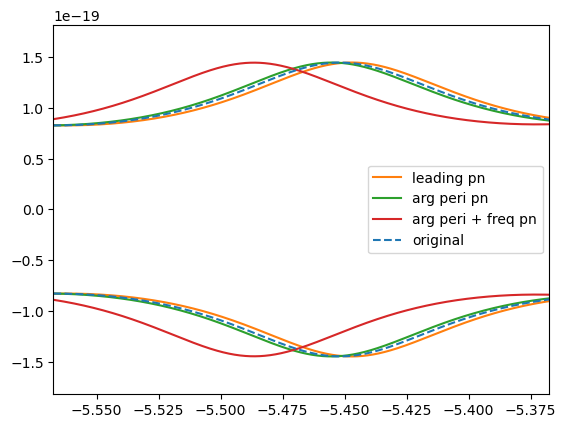

In [52]:
# Params
f_low, e, M, q, chi1, chi2 = norm_f_low, norm_e, norm_M, norm_q, norm_chi1, norm_chi2

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)
s_hs = []
for s_f_eqn in [shifted_f_1, shifted_f_2, shifted_f_3]:
    s_f = s_f_eqn(f_low, e, M, q, chi1, chi2)
    s_e = shifted_e(s_f, f_low, e)
    s_hs.append(gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2))

# Plot
for i, label in enumerate(['leading pn', 'arg peri pn', 'arg peri + freq pn']):
    plt.plot(s_hs[i].sample_times, np.abs(s_hs[i]), c=f'C{i+1}', label=label)
    plt.plot(s_hs[i].sample_times, -np.abs(s_hs[i]), c=f'C{i+1}')
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', label='original')
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed')
plt.xlim(h.sample_times[0], h.sample_times[0]+0.2)
plt.ylim(-1.25*np.max(np.array(np.abs(h[:2048]))), 1.25*np.max(np.array(np.abs(h[:2048]))))
plt.legend()

1.16015184899792


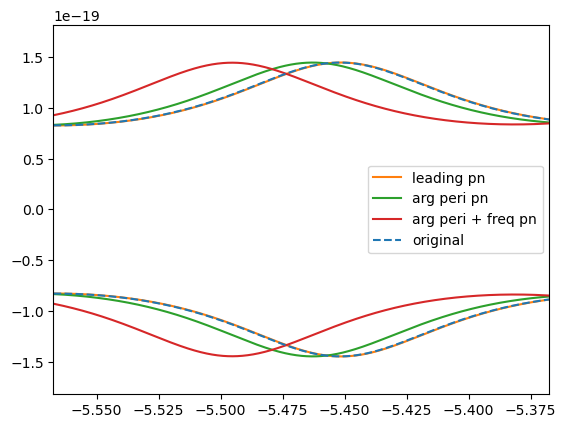

In [7]:
# Params
f_low, e, M, q, chi1, chi2 = norm_f_low, norm_e, norm_M, norm_q, norm_chi1, norm_chi2

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)
s_hs = []
for s_f_eqn in [shifted_f_1, shifted_f_2, shifted_f_3]:
    s_f = s_f_eqn(f_low, e, M, q, chi1, chi2)
    s_e = shifted_e(s_f, f_low, e)
    s_hs.append(gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2))

# Plot
for i, label in enumerate(['leading pn', 'arg peri pn', 'arg peri + freq pn']):
    plt.plot(s_hs[i].sample_times, np.abs(s_hs[i]), c=f'C{i+1}', label=label)
    plt.plot(s_hs[i].sample_times, -np.abs(s_hs[i]), c=f'C{i+1}')
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', label='original')
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed')
plt.xlim(h.sample_times[0], h.sample_times[0]+0.2)
plt.ylim(-1.25*np.max(np.array(np.abs(h[:2048]))), 1.25*np.max(np.array(np.abs(h[:2048]))))
plt.legend()

### High eccentricity

1.176696151365359


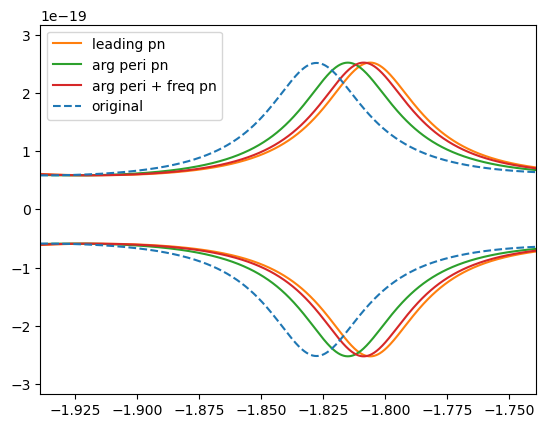

In [53]:
# Params
f_low, e, M, q, chi1, chi2 = norm_f_low, hi_e, norm_M, norm_q, norm_chi1, norm_chi2

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)
s_hs = []
for s_f_eqn in [shifted_f_1, shifted_f_2, shifted_f_3]:
    s_f = s_f_eqn(f_low, e, M, q, chi1, chi2)
    s_e = shifted_e(s_f, f_low, e)
    s_hs.append(gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2))

# Plot
for i, label in enumerate(['leading pn', 'arg peri pn', 'arg peri + freq pn']):
    plt.plot(s_hs[i].sample_times, np.abs(s_hs[i]), c=f'C{i+1}', label=label)
    plt.plot(s_hs[i].sample_times, -np.abs(s_hs[i]), c=f'C{i+1}')
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', label='original')
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed')
plt.xlim(h.sample_times[0], h.sample_times[0]+0.2)
plt.ylim(-1.25*np.max(np.array(np.abs(h[:2048]))), 1.25*np.max(np.array(np.abs(h[:2048]))))
plt.legend()

In [ ]:
# Params
f_low, e, M, q, chi1, chi2 = norm_f_low, hi_e, norm_M, norm_q, norm_chi1, norm_chi2

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)
s_hs = []
for s_f_eqn in [shifted_f_1, shifted_f_2, shifted_f_3]:
    s_f = s_f_eqn(f_low, e, M, q, chi1, chi2)
    s_e = shifted_e(s_f, f_low, e)
    s_hs.append(gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2))

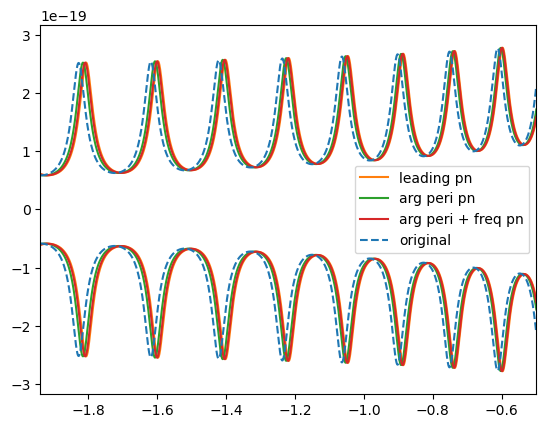

In [56]:
# Plot
for i, label in enumerate(['leading pn', 'arg peri pn', 'arg peri + freq pn']):
    plt.plot(s_hs[i].sample_times, np.abs(s_hs[i]), c=f'C{i+1}', label=label)
    plt.plot(s_hs[i].sample_times, -np.abs(s_hs[i]), c=f'C{i+1}')
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', label='original')
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed')
plt.xlim(h.sample_times[0], -0.5)
plt.ylim(-1.25*np.max(np.array(np.abs(h[:2048]))), 1.25*np.max(np.array(np.abs(h[:2048]))))
plt.legend()

### High mass ratio

1.16015184899792


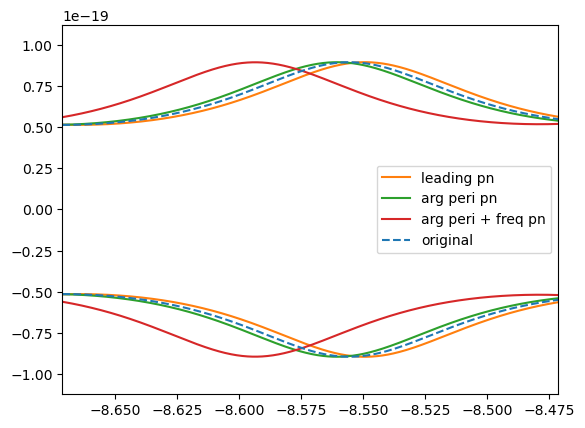

In [10]:
# Params
f_low, e, M, q, chi1, chi2 = norm_f_low, norm_e, norm_M, hi_q, norm_chi1, norm_chi2

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)
s_hs = []
for s_f_eqn in [shifted_f_1, shifted_f_2, shifted_f_3]:
    s_f = s_f_eqn(f_low, e, M, q, chi1, chi2)
    s_e = shifted_e(s_f, f_low, e)
    s_hs.append(gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2))

# Plot
for i, label in enumerate(['leading pn', 'arg peri pn', 'arg peri + freq pn']):
    plt.plot(s_hs[i].sample_times, np.abs(s_hs[i]), c=f'C{i+1}', label=label)
    plt.plot(s_hs[i].sample_times, -np.abs(s_hs[i]), c=f'C{i+1}')
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', label='original')
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed')
plt.xlim(h.sample_times[0], h.sample_times[0]+0.2)
plt.ylim(-1.25*np.max(np.array(np.abs(h[:2048]))), 1.25*np.max(np.array(np.abs(h[:2048]))))
plt.legend()

### Aligned spin (+ve)

1.16015184899792


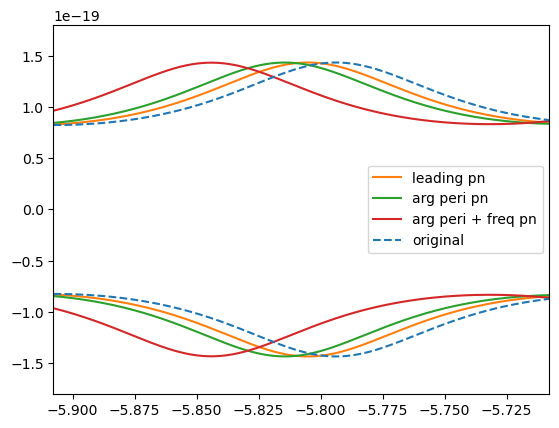

In [11]:
# Params
f_low, e, M, q, chi1, chi2 = norm_f_low, norm_e, norm_M, norm_q, hi_chi1, norm_chi2

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)
s_hs = []
for s_f_eqn in [shifted_f_1, shifted_f_2, shifted_f_3]:
    s_f = s_f_eqn(f_low, e, M, q, chi1, chi2)
    s_e = shifted_e(s_f, f_low, e)
    s_hs.append(gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2))

# Plot
for i, label in enumerate(['leading pn', 'arg peri pn', 'arg peri + freq pn']):
    plt.plot(s_hs[i].sample_times, np.abs(s_hs[i]), c=f'C{i+1}', label=label)
    plt.plot(s_hs[i].sample_times, -np.abs(s_hs[i]), c=f'C{i+1}')
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', label='original')
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed')
plt.xlim(h.sample_times[0], h.sample_times[0]+0.2)
plt.ylim(-1.25*np.max(np.array(np.abs(h[:2048]))), 1.25*np.max(np.array(np.abs(h[:2048]))))
plt.legend()

### High eccentricity, high mass ratio, aligned spin (+ve)

1.2146183959401988


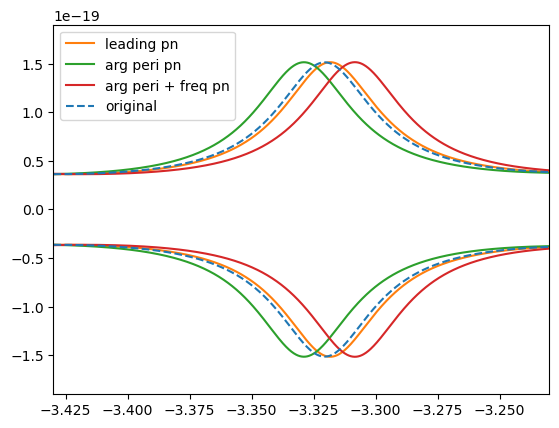

In [12]:
# Params
f_low, e, M, q, chi1, chi2 = norm_f_low, hi_e, norm_M, hi_q, hi_chi1, norm_chi2

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)
s_hs = []
for s_f_eqn in [shifted_f_1, shifted_f_2, shifted_f_3]:
    s_f = s_f_eqn(f_low, e, M, q, chi1, chi2)
    s_e = shifted_e(s_f, f_low, e)
    s_hs.append(gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2))

# Plot
for i, label in enumerate(['leading pn', 'arg peri pn', 'arg peri + freq pn']):
    plt.plot(s_hs[i].sample_times, np.abs(s_hs[i]), c=f'C{i+1}', label=label)
    plt.plot(s_hs[i].sample_times, -np.abs(s_hs[i]), c=f'C{i+1}')
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', label='original')
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed')
plt.xlim(h.sample_times[0], h.sample_times[0]+0.2)
plt.ylim(-1.25*np.max(np.array(np.abs(h[:2048]))), 1.25*np.max(np.array(np.abs(h[:2048]))))
plt.legend()

# Equations from Henry and Khalil

(Note we are dropping $\left< \ldots \right>$ notation here)

Let's now turn to Henry and Khalil 2024 (https://journals.aps.org/prd/pdf/10.1103/PhysRevD.108.104016), which have these evolution equations up to 2pn and second spin order (up to 3pn, we will only use up to 2pn for consistency) in their supplementary material. We will not repeat them here as they are rather long. They are for $de/dt$, $da/dt$, and $dx/dt$, the latter two can each be trivially converted to $df/dt$. They also contain expressions for $K$, which is defined as the ratio between $f_\mathrm{az}$ and $f_\mathrm{rad}$, so we can just use $K$ directly instead of ever calculating $d\gamma/dt$.

To convert from $da/dt$ to $df/dt$ (with $f$ here being the gravitational wave frequency), we start from

$$
a = \left(\frac{GMP_\mathrm{az}^2}{4\pi^2}\right)^{1/3},
$$

$$
a = \left(\frac{GM}{f^2\pi^2}\right)^{1/3},
$$

$$
f = \left(\frac{\pi^2}{GMa^3}\right)^{1/2},
$$

$$
\frac{df}{dt} = \frac{-3}{2}\left(\frac{\pi^2}{GMa^5}\right)^{1/2} \frac{da}{dt},
$$

$$
\frac{df}{dt} = \frac{-3}{2}\left(\frac{\pi^2}{GM}\right)^{1/2} \left(\frac{f^2\pi^2}{GM}\right)^{5/6} \frac{da}{dt},
$$

$$
\frac{df}{dt} = \frac{-3f^{5/3}}{2}\left(\frac{\pi^2}{GM}\right)^{4/3} \frac{da}{dt}.
$$

We can do the same for $dx/dt$:

$$
x = \left(\frac{GM \pi f}{c^3}\right)^{2/3},
$$

$$
f = \frac{x^{3/2}c^3}{GM\pi},
$$

$$
\frac{df}{dt} = \frac{3}{2}\frac{x^{1/2}c^3}{GM\pi} \frac{dx}{dt},
$$

$$
\frac{df}{dt} = \frac{3}{2}\frac{c^3}{GM\pi} \left(\frac{GM \pi f}{c^3}\right)^{1/3} \frac{dx}{dt},
$$

$$
\frac{df}{dt} = \frac{3f^{1/3}}{2}  \left(\frac{c^3}{GM\pi}\right)^{2/3} \frac{dx}{dt}.
$$

We would hope that using either equation should give consistent results, and we can code both up to make sure.

## Mathematica expressions

The following are mathematica expressions for these evolution equations, copied directly from the supplementary material:

(*
Notation:
We use geometric units with c = G = 1
\[Nu] = m1 m2 / M^2 is the symmetric mass ratio 
\[Delta] = (m1 - m2) / M is the antisymmetric mass ratio 
M = m1 + m2 is the total mass

\[Epsilon] = 1 is a PN counting parameter
SO = 1 is a spin order counting parameter

x = (M \[CapitalOmega])^(2/3), where \[CapitalOmega] is the azimuthal orbital frequency
e = e_t is the time eccentricity
K is the periastron advance
\[ScriptL] is the mean anomaly
ar is the semi-major axis
\[Gamma]E = 0.577... is the EulerGamma constant
rd and \[Phi]d denote dr/dt and d\[Phi]/dt, repsectively

\[Chi]1 = S1 / m1^2, and \[Chi]2 = S2 / m2^2 are the dimensionless spins
\[Chi]S = 1/2 (\[Chi]1 + \[Chi]2) 
\[Chi]A = 1/2 (\[Chi]1 - \[Chi]2)
\[Kappa]1 and \[Kappa]2 are the spin quadrupole constants, which equal 1 for black holes
\[Kappa]S = 1/2 ((\[Kappa]1 - 1) \[Chi]1^2 + (\[Kappa]2 - 1) \[Chi]2^2)
\[Kappa]A = 1/2 ((\[Kappa]1 - 1) \[Chi]1^2 - (\[Kappa]2 - 1) \[Chi]2^2)

The energy flux is split into instantaneous + tail contributions, and is denoted
\[ScriptCapitalF] = \[ScriptCapitalF]inst + \[ScriptCapitalF]tail
The angular momentum flux (the component in the direction of orbital angular momentum) is denoted
\[ScriptCapitalG] = \[ScriptCapitalG]inst + \[ScriptCapitalG]tail
*)

(* ::Section:: *)
(*de/dt, dar/dt, and dx/dt*)


(* ::Text:: *)
(*The time derivative of the osculating orbital elements e, ar, x, and K. *)
(*We added a factor flagTail = 1 to separate the tail from the instantaneous contributions to the orbit-averaged fluxes.*)


(* ::Subsection::Closed:: *)
(*de/dt*)


dedt = -(e*(304 + 121*e^2)*x^4*\[Nu])/(15*(1 - e^2)^(5/2)*M) - 
    (e*(4538880 + 6876288*e^2 + 581208*e^4 + 623*e^6)*flagTail*Pi*x^(11/2)*
      \[Epsilon]^3*\[Nu])/(34560*(-1 + e^2)^4*M) + 
    (e*x^5*\[Epsilon]^2*\[Nu]*(8*(8451 + 28588*\[Nu]) + 
       12*e^2*(-59834 + 54271*\[Nu]) + e^4*(-125361 + 93184*\[Nu])))/
     (2520*(1 - e^2)^(7/2)*M) + (e*x^6*\[Epsilon]^4*\[Nu]*
      ((1008*(2672 + 6963*e^2 + 565*e^4)*(-5 + 2*\[Nu]))/(-1 + e^2)^4 - 
       (16*(-949877 + 844335*\[Nu] + 284256*\[Nu]^2) + 
         3*e^6*(1262181 - 1448284*\[Nu] + 919520*\[Nu]^2) + 
         12*e^2*(-3082783 - 2965269*\[Nu] + 4059279*\[Nu]^2) + 
         e^4*(46579718 - 78112266*\[Nu] + 42810096*\[Nu]^2))/
        (1 - e^2)^(9/2)))/(30240*M) + 
    SO*((e*x^(11/2)*\[Epsilon]^3*\[Nu]*((19688 + 28256*e^2 + 2367*e^4)*
          \[Delta]*\[Chi]A + (19688 + e^2*(28256 - 7972*\[Nu]) - 
           13312*\[Nu] + 3*e^4*(789 + 92*\[Nu]))*\[Chi]S))/
       (90*(-1 + e^2)^4*M) + (e*flagTail*Pi*x^7*\[Epsilon]^6*\[Nu]*
        ((64622592 + 238783104*e^2 + 96887280*e^4 + 2313613*e^6)*\[Delta]*
          \[Chi]A + (-9216*(-7012 + 4937*\[Nu]) - 1152*e^2*
            (-207277 + 74954*\[Nu]) - 48*e^4*(-2018485 + 95561*\[Nu]) + 
           e^6*(2313613 + 1263046*\[Nu]))*\[Chi]S))/(51840*(1 - e^2)^(11/2)*
        M) + (e*x^(13/2)*\[Epsilon]^5*\[Nu]*
        ((-2688*(2960 + 6927*e^2 + 313*e^4)*(2*\[Delta]*(-3 + \[Nu])*
             \[Chi]A - (6 - 8*\[Nu] + \[Nu]^2)*\[Chi]S))/(1 - e^2)^(9/2) + 
         (\[Delta]*(9*e^6*(-1037433 + 955808*\[Nu]) + 
             64*(-324747 + 1197434*\[Nu]) + 56*e^4*(-4389075 + 3676346*
                \[Nu]) + 48*e^2*(-6885449 + 7330106*\[Nu]))*\[Chi]A + 
           (3*e^6*(-3112299 + 2662908*\[Nu] + 336896*\[Nu]^2) - 
             64*(324747 - 1788860*\[Nu] + 740824*\[Nu]^2) - 
             48*e^2*(6885449 - 12914742*\[Nu] + 3551324*\[Nu]^2) - 
             8*e^4*(30723525 - 36750368*\[Nu] + 6313216*\[Nu]^2))*\[Chi]S)/
          (-1 + e^2)^5))/(60480*M)) + 
    SO^2*(-(e*x^6*\[Epsilon]^4*\[Nu]*(4*(3752 + 5950*e^2 + 555*e^4)*\[Delta]*
           \[Kappa]A - 4*(3752 + 5950*e^2 + 555*e^4)*\[Kappa]S*
           (-1 + 2*\[Nu]) + 15368*\[Chi]A^2 + 24340*e^2*\[Chi]A^2 + 
          2265*e^4*\[Chi]A^2 - 60032*\[Nu]*\[Chi]A^2 - 95200*e^2*\[Nu]*
           \[Chi]A^2 - 8880*e^4*\[Nu]*\[Chi]A^2 + 
          2*(15368 + 24340*e^2 + 2265*e^4)*\[Delta]*\[Chi]A*\[Chi]S + 
          15368*\[Chi]S^2 + 24340*e^2*\[Chi]S^2 + 2265*e^4*\[Chi]S^2 - 
          1440*\[Nu]*\[Chi]S^2 - 2160*e^2*\[Nu]*\[Chi]S^2 - 
          180*e^4*\[Nu]*\[Chi]S^2))/(120*(1 - e^2)^(9/2)*M) + 
      (e*x^7*\[Epsilon]^6*\[Nu]*
        (-((6*\[Kappa]S*(9*e^6*(184470 - 516661*\[Nu] + 288288*\[Nu]^2) + 
              32*(89793 - 527402*\[Nu] + 404908*\[Nu]^2) + 48*e^2*(847619 - 
                2691660*\[Nu] + 1530550*\[Nu]^2) + 4*e^4*(8317317 - 
                23483168*\[Nu] + 12461848*\[Nu]^2)) + 88499360*\[Chi]A^2 + 
            477482624*e^2*\[Chi]A^2 + 275826708*e^4*\[Chi]A^2 + 
            11414979*e^6*\[Chi]A^2 - 399608096*\[Nu]*\[Chi]A^2 - 
            2115049424*e^2*\[Nu]*\[Chi]A^2 - 1236732852*e^4*\[Nu]*\[Chi]A^2 - 
            52550856*e^6*\[Nu]*\[Chi]A^2 + 155484672*\[Nu]^2*\[Chi]A^2 + 
            881596800*e^2*\[Nu]^2*\[Chi]A^2 + 598168704*e^4*\[Nu]^2*
             \[Chi]A^2 + 31135104*e^6*\[Nu]^2*\[Chi]A^2 + 
            88499360*\[Chi]S^2 + 477482624*e^2*\[Chi]S^2 + 
            275826708*e^4*\[Chi]S^2 + 11414979*e^6*\[Chi]S^2 - 
            219613856*\[Nu]*\[Chi]S^2 - 624223376*e^2*\[Nu]*\[Chi]S^2 - 
            235260900*e^4*\[Nu]*\[Chi]S^2 - 8905680*e^6*\[Nu]*\[Chi]S^2 + 
            58808960*\[Nu]^2*\[Chi]S^2 + 83203904*e^2*\[Nu]^2*\[Chi]S^2 + 
            15245328*e^4*\[Nu]^2*\[Chi]S^2 + 707616*e^6*\[Nu]^2*\[Chi]S^2 - 
            2*\[Delta]*(3*\[Kappa]A*(9*e^6*(-184470 + 147721*\[Nu]) + 
                32*(-89793 + 347816*\[Nu]) + 48*e^2*(-847619 + 996422*
                   \[Nu]) + 4*e^4*(-8317317 + 6848534*\[Nu])) + 
              (27*e^6*(-422777 + 292530*\[Nu]) + 32*(-2765605 + 4144133*
                   \[Nu]) + 12*e^4*(-22985559 + 15361955*\[Nu]) + 
                16*e^2*(-29842664 + 25916947*\[Nu]))*\[Chi]A*\[Chi]S))/
           (1 - e^2)^(11/2)) - (672*(3248 + 6891*e^2 + 61*e^4)*
           (\[Delta]*\[Kappa]A*(-14 + 5*\[Nu]) + \[Kappa]S*(-14 + 33*\[Nu] - 
              6*\[Nu]^2) + 4*\[Delta]*(-11 + 9*\[Nu])*\[Chi]A*\[Chi]S - 
            2*((11 - 46*\[Nu] + 6*\[Nu]^2)*\[Chi]A^2 + (11 - 16*\[Nu] + 
                4*\[Nu]^2)*\[Chi]S^2)))/(-1 + e^2)^5))/(60480*M))


(* ::Subsection::Closed:: *)
(*dar/dt*)


dardt = (-2*(96 + 292*e^2 + 37*e^4)*x^3*\[Nu])/(15*(1 - e^2)^(7/2)) + 
    ((884736 + 6336000*e^2 + 4533120*e^4 + 240168*e^6 + 2321*e^8)*flagTail*Pi*
      x^(9/2)*\[Epsilon]^3*\[Nu])/(17280*(-1 + e^2)^5) + 
    (x^4*\[Epsilon]^2*\[Nu]*(16*(743 + 924*\[Nu]) + 
       42*e^4*(-4395 + 3374*\[Nu]) + e^6*(-11717 + 8288*\[Nu]) + 
       8*e^2*(-15221 + 19950*\[Nu])))/(420*(1 - e^2)^(9/2)) + 
    (x^5*\[Epsilon]^4*\[Nu]*((-9072*(96 + 1452*e^2 + 1353*e^4 + 74*e^6)*
         (-5 + 2*\[Nu]))/(-1 + e^2)^5 - 
       (32*(-101977 + 91197*\[Nu] + 57456*\[Nu]^2) + 
         9*e^8*(366593 - 372580*\[Nu] + 215488*\[Nu]^2) + 
         18*e^6*(5415685 - 7562485*\[Nu] + 3593464*\[Nu]^2) + 
         16*e^2*(-4684354 - 690732*\[Nu] + 3825927*\[Nu]^2) + 
         12*e^4*(5851846 - 21598440*\[Nu] + 13900761*\[Nu]^2))/
        (1 - e^2)^(11/2)))/45360 + 
    SO*((x^(9/2)*\[Epsilon]^3*\[Nu]*
        (-((1744 + 10640*e^2 + 6290*e^4 + 363*e^6)*\[Delta]*\[Chi]A) + 
         (3*e^6*(-121 + 48*\[Nu]) + 16*(-109 + 80*\[Nu]) + 
           8*e^2*(-1330 + 633*\[Nu]) + 2*e^4*(-3145 + 824*\[Nu]))*\[Chi]S))/
       (15*(-1 + e^2)^5) - (flagTail*Pi*x^6*\[Epsilon]^6*\[Nu]*
        (-((15998976 + 197535744*e^2 + 306116352*e^4 + 79068896*e^6 + 
            1988243*e^8)*\[Delta]*\[Chi]A) + (73728*(-217 + 156*\[Nu]) + 
           129024*e^2*(-1531 + 746*\[Nu]) + 2304*e^4*(-132863 + 
             39592*\[Nu]) + e^8*(-1988243 + 332980*\[Nu]) + 
           32*e^6*(-2470903 + 402702*\[Nu]))*\[Chi]S))/
       (34560*(1 - e^2)^(13/2)) + (x^(11/2)*\[Epsilon]^5*\[Nu]*
        (\[Delta]*(e^6*(51430096 - 39021136*\[Nu]) + 
           256*(9983 - 22869*\[Nu]) - 15*e^8*(-103805 + 81312*\[Nu]) - 
           128*e^2*(-461275 + 549213*\[Nu]) - 48*e^4*(-3114327 + 
             2651110*\[Nu]))*\[Chi]A + 
         (128*(19966 - 76121*\[Nu] + 27468*\[Nu]^2) + 
           15*e^8*(103805 - 126308*\[Nu] + 32256*\[Nu]^2) + 
           128*e^2*(461275 - 989003*\[Nu] + 293139*\[Nu]^2) + 
           16*e^6*(3214381 - 3588783*\[Nu] + 658364*\[Nu]^2) + 
           48*e^4*(3114327 - 4457537*\[Nu] + 1059912*\[Nu]^2))*\[Chi]S - 
         2688*Sqrt[1 - e^2]*(96 + 1452*e^2 + 1353*e^4 + 74*e^6)*
          (2*\[Delta]*(-3 + \[Nu])*\[Chi]A - (6 - 8*\[Nu] + \[Nu]^2)*
            \[Chi]S)))/(10080*(-1 + e^2)^6)) + 
    SO^2*((x^5*\[Epsilon]^4*\[Nu]*(4*(864 + 5908*e^2 + 4074*e^4 + 261*e^6)*
          \[Kappa]S*(-1 + 2*\[Nu]) - 3504*\[Chi]A^2 - 24088*e^2*\[Chi]A^2 - 
         16710*e^4*\[Chi]A^2 - 1071*e^6*\[Chi]A^2 + 13824*\[Nu]*\[Chi]A^2 + 
         94528*e^2*\[Nu]*\[Chi]A^2 + 65184*e^4*\[Nu]*\[Chi]A^2 + 
         4176*e^6*\[Nu]*\[Chi]A^2 - 3504*\[Chi]S^2 - 24088*e^2*\[Chi]S^2 - 
         16710*e^4*\[Chi]S^2 - 1071*e^6*\[Chi]S^2 + 192*\[Nu]*\[Chi]S^2 + 
         1824*e^2*\[Nu]*\[Chi]S^2 + 1656*e^4*\[Nu]*\[Chi]S^2 + 
         108*e^6*\[Nu]*\[Chi]S^2 - 2*\[Delta]*
          (2*(864 + 5908*e^2 + 4074*e^4 + 261*e^6)*\[Kappa]A + 
           (3504 + 24088*e^2 + 16710*e^4 + 1071*e^6)*\[Chi]A*\[Chi]S)))/
       (60*(1 - e^2)^(11/2)) + (x^6*\[Epsilon]^6*\[Nu]*
        (-((2*\[Kappa]S*(672*(1611 - 6430*\[Nu] + 3768*\[Nu]^2) + 
              3*e^8*(251238 - 684175*\[Nu] + 370272*\[Nu]^2) + 
              32*e^2*(621186 - 2087839*\[Nu] + 1171478*\[Nu]^2) + 
              24*e^6*(867233 - 2404688*\[Nu] + 1214472*\[Nu]^2) + 
              28*e^4*(1896303 - 5543242*\[Nu] + 2860208*\[Nu]^2)) + 
            8461824*\[Chi]A^2 + 99525600*e^2*\[Chi]A^2 + 185494848*e^4*
             \[Chi]A^2 + 60124740*e^6*\[Chi]A^2 + 2042865*e^8*\[Chi]A^2 - 
            37205952*\[Nu]*\[Chi]A^2 - 436247584*e^2*\[Nu]*\[Chi]A^2 - 
            815985464*e^4*\[Nu]*\[Chi]A^2 - 266013876*e^6*\[Nu]*\[Chi]A^2 - 
            9151320*e^8*\[Nu]*\[Chi]A^2 + 10128384*\[Nu]^2*\[Chi]A^2 + 
            149949184*e^2*\[Nu]^2*\[Chi]A^2 + 320343296*e^4*\[Nu]^2*
             \[Chi]A^2 + 116589312*e^6*\[Nu]^2*\[Chi]A^2 + 
            4443264*e^8*\[Nu]^2*\[Chi]A^2 + 8461824*\[Chi]S^2 + 
            99525600*e^2*\[Chi]S^2 + 185494848*e^4*\[Chi]S^2 + 
            60124740*e^6*\[Chi]S^2 + 2042865*e^8*\[Chi]S^2 - 
            19217856*\[Nu]*\[Chi]S^2 - 153046432*e^2*\[Nu]*\[Chi]S^2 - 
            197119160*e^4*\[Nu]*\[Chi]S^2 - 52562244*e^6*\[Nu]*\[Chi]S^2 - 
            1660176*e^8*\[Nu]*\[Chi]S^2 + 6123264*\[Nu]^2*\[Chi]S^2 + 
            29006208*e^2*\[Nu]^2*\[Chi]S^2 + 23261280*e^4*\[Nu]^2*\[Chi]S^2 + 
            5547024*e^6*\[Nu]^2*\[Chi]S^2 + 69216*e^8*\[Nu]^2*\[Chi]S^2 - 
            2*\[Delta]*(\[Kappa]A*(672*(-1611 + 3208*\[Nu]) + 
                e^8*(-753714 + 545097*\[Nu]) + 24*e^6*(-867233 + 
                  670222*\[Nu]) + 32*e^2*(-621186 + 845467*\[Nu]) + 
                28*e^4*(-1896303 + 1750636*\[Nu])) + 
              (1344*(-6296 + 8399*\[Nu]) + 3*e^8*(-680955 + 440006*\[Nu]) + 
                60*e^6*(-1002079 + 650643*\[Nu]) + 56*e^4*(-3312408 + 
                  2420761*\[Nu]) + 32*e^2*(-3110175 + 2987369*\[Nu]))*\[Chi]A*
               \[Chi]S))/(1 - e^2)^(13/2)) + 
         (672*(96 + 1452*e^2 + 1353*e^4 + 74*e^6)*
           (\[Delta]*\[Kappa]A*(-14 + 5*\[Nu]) + \[Kappa]S*(-14 + 33*\[Nu] - 
              6*\[Nu]^2) + 4*\[Delta]*(-11 + 9*\[Nu])*\[Chi]A*\[Chi]S - 
            2*((11 - 46*\[Nu] + 6*\[Nu]^2)*\[Chi]A^2 + (11 - 16*\[Nu] + 
                4*\[Nu]^2)*\[Chi]S^2)))/(-1 + e^2)^6))/10080)


(* ::Subsection::Closed:: *)
(*dx/dt*)


dxdt = (2*(96 + 292*e^2 + 37*e^4)*x^5*\[Nu])/(15*(1 - e^2)^(7/2)*M) - 
    ((884736 + 6336000*e^2 + 4533120*e^4 + 240168*e^6 + 2321*e^8)*flagTail*Pi*
      x^(13/2)*\[Epsilon]^3*\[Nu])/(17280*(-1 + e^2)^5*M) - 
    (x^6*\[Epsilon]^2*\[Nu]*(16*(743 + 924*\[Nu]) + 
       120*e^2*(-731 + 1330*\[Nu]) + e^6*(-11717 + 8288*\[Nu]) + 
       14*e^4*(-12217 + 10122*\[Nu])))/(420*(1 - e^2)^(9/2)*M) - 
    (x^7*\[Epsilon]^4*\[Nu]*(3024*Sqrt[1 - e^2]*(96 + 4268*e^2 + 4386*e^4 + 
         175*e^6)*(-5 + 2*\[Nu]) - 32*(-11257 + 141093*\[Nu] + 
         59472*\[Nu]^2) - 3*e^8*(1174371 - 1086660*\[Nu] + 654752*\[Nu]^2) - 
       16*e^2*(-5802910 + 966546*\[Nu] + 3830127*\[Nu]^2) - 
       6*e^6*(13904067 - 20518071*\[Nu] + 10804808*\[Nu]^2) - 
       12*e^4*(65314 - 17267022*\[Nu] + 13875505*\[Nu]^2)))/
     (45360*(1 - e^2)^(11/2)*M) + 
    SO*((x^(13/2)*\[Epsilon]^3*\[Nu]*((5424 + 27608*e^2 + 16694*e^4 + 
           585*e^6)*\[Delta]*\[Chi]A + (5424 + e^4*(16694 - 4072*\[Nu]) - 
           3648*\[Nu] + 9*e^6*(65 + 8*\[Nu]) - 8*e^2*(-3451 + 1670*\[Nu]))*
          \[Chi]S))/(45*(-1 + e^2)^5*M) - (flagTail*Pi*x^8*\[Epsilon]^6*\[Nu]*
        ((49766400 + 528887808*e^2 + 814424832*e^4 + 213166272*e^6 + 
           3911917*e^8)*\[Delta]*\[Chi]A + (-221184*(-225 + 148*\[Nu]) - 
           18432*e^2*(-28694 + 13789*\[Nu]) - 2304*e^4*(-353483 + 
             101614*\[Nu]) - 96*e^6*(-2220482 + 214925*\[Nu]) + 
           e^8*(3911917 + 1055680*\[Nu]))*\[Chi]S))/(103680*(1 - e^2)^(13/2)*
        M) + (x^(15/2)*\[Epsilon]^5*\[Nu]*
        (\[Delta]*(45*e^8*(-17967 + 14560*\[Nu]) + 
           128*(-31319 + 48678*\[Nu]) + 224*e^4*(-505492 + 493737*\[Nu]) + 
           128*e^2*(-334209 + 496090*\[Nu]) + 16*e^6*(-2581907 + 
             2083557*\[Nu]))*\[Chi]A + 
         (45*e^8*(-17967 + 12924*\[Nu] + 1792*\[Nu]^2) - 
           128*(31319 - 91900*\[Nu] + 26544*\[Nu]^2) - 
           448*e^4*(252746 - 403471*\[Nu] + 98766*\[Nu]^2) - 
           128*e^2*(334209 - 828514*\[Nu] + 266042*\[Nu]^2) - 
           16*e^6*(2581907 - 2894533*\[Nu] + 469140*\[Nu]^2))*\[Chi]S + 
         896*e^2*Sqrt[1 - e^2]*(4376 + 4458*e^2 + 91*e^4)*
          (2*\[Delta]*(-3 + \[Nu])*\[Chi]A - (6 - 8*\[Nu] + \[Nu]^2)*
            \[Chi]S)))/(10080*(-1 + e^2)^6*M)) + 
    SO^2*((x^7*\[Epsilon]^4*\[Nu]*(4*(960 + 5384*e^2 + 3736*e^4 + 177*e^6)*
          \[Delta]*\[Kappa]A - 4*(960 + 5384*e^2 + 3736*e^4 + 177*e^6)*
          \[Kappa]S*(-1 + 2*\[Nu]) + 3888*\[Chi]A^2 + 21992*e^2*\[Chi]A^2 + 
         15358*e^4*\[Chi]A^2 + 735*e^6*\[Chi]A^2 - 15360*\[Nu]*\[Chi]A^2 - 
         86144*e^2*\[Nu]*\[Chi]A^2 - 59776*e^4*\[Nu]*\[Chi]A^2 - 
         2832*e^6*\[Nu]*\[Chi]A^2 + 2*(3888 + 21992*e^2 + 15358*e^4 + 
           735*e^6)*\[Delta]*\[Chi]A*\[Chi]S + 3888*\[Chi]S^2 + 
         21992*e^2*\[Chi]S^2 + 15358*e^4*\[Chi]S^2 + 735*e^6*\[Chi]S^2 - 
         192*\[Nu]*\[Chi]S^2 - 1824*e^2*\[Nu]*\[Chi]S^2 - 
         1656*e^4*\[Nu]*\[Chi]S^2 - 108*e^6*\[Nu]*\[Chi]S^2))/
       (60*(1 - e^2)^(11/2)*M) + (x^8*\[Epsilon]^6*\[Nu]*
        ((6*\[Kappa]S*(192*(8963 - 31632*\[Nu] + 14784*\[Nu]^2) + 
             224*e^2*(70203 - 254204*\[Nu] + 160324*\[Nu]^2) + 
             3*e^8*(164778 - 456935*\[Nu] + 251104*\[Nu]^2) + 
             28*e^6*(624771 - 1759522*\[Nu] + 937088*\[Nu]^2) + 
             8*e^4*(5381787 - 16375838*\[Nu] + 9140320*\[Nu]^2)) + 
           32150592*\[Chi]A^2 + 236283488*e^2*\[Chi]A^2 + 
           439738616*e^4*\[Chi]A^2 + 141676164*e^6*\[Chi]A^2 + 
           3374811*e^8*\[Chi]A^2 - 139984704*\[Nu]*\[Chi]A^2 - 
           1054958240*e^2*\[Nu]*\[Chi]A^2 - 1959961928*e^4*\[Nu]*\[Chi]A^2 - 
           633764796*e^6*\[Nu]*\[Chi]A^2 - 15271560*e^8*\[Nu]*\[Chi]A^2 + 
           34062336*\[Nu]^2*\[Chi]A^2 + 430950912*e^2*\[Nu]^2*\[Chi]A^2 + 
           877470720*e^4*\[Nu]^2*\[Chi]A^2 + 314861568*e^6*\[Nu]^2*
            \[Chi]A^2 + 9039744*e^8*\[Nu]^2*\[Chi]A^2 + 32150592*\[Chi]S^2 + 
           236283488*e^2*\[Chi]S^2 + 439738616*e^4*\[Chi]S^2 + 
           141676164*e^6*\[Chi]S^2 + 3374811*e^8*\[Chi]S^2 - 
           67507776*\[Nu]*\[Chi]S^2 - 389245472*e^2*\[Nu]*\[Chi]S^2 - 
           507132584*e^4*\[Nu]*\[Chi]S^2 - 121365132*e^6*\[Nu]*\[Chi]S^2 - 
           2752848*e^8*\[Nu]*\[Chi]S^2 + 19272960*\[Nu]^2*\[Chi]S^2 + 
           71582336*e^2*\[Nu]^2*\[Chi]S^2 + 57059744*e^4*\[Nu]^2*\[Chi]S^2 + 
           9706032*e^6*\[Nu]^2*\[Chi]S^2 + 344736*e^8*\[Nu]^2*\[Chi]S^2 - 
           2*\[Delta]*(3*\[Kappa]A*(192*(-8963 + 13706*\[Nu]) + 224*e^2*
                (-70203 + 113798*\[Nu]) + e^8*(-494334 + 382137*\[Nu]) + 28*
                e^6*(-624771 + 509980*\[Nu]) + 8*e^4*(-5381787 + 
                 5612264*\[Nu])) + (576*(-55817 + 68481*\[Nu]) + 9*e^8*
                (-374979 + 251398*\[Nu]) + 224*e^2*(-1054837 + 1113995*
                  \[Nu]) + 84*e^6*(-1686621 + 1121579*\[Nu]) + 8*e^4*
                (-54967327 + 44258753*\[Nu]))*\[Chi]A*\[Chi]S))/
          (1 - e^2)^(13/2) - (672*(-96 + 4484*e^2 + 4530*e^4 + 7*e^6)*
           (\[Delta]*\[Kappa]A*(-14 + 5*\[Nu]) + \[Kappa]S*(-14 + 33*\[Nu] - 
              6*\[Nu]^2) + 4*\[Delta]*(-11 + 9*\[Nu])*\[Chi]A*\[Chi]S - 
            2*((11 - 46*\[Nu] + 6*\[Nu]^2)*\[Chi]A^2 + (11 - 16*\[Nu] + 
                4*\[Nu]^2)*\[Chi]S^2)))/(-1 + e^2)^6))/(30240*M))


(* ::Subsection::Closed:: *)
(*dK/dt*)


dKdt = (24*(8 + 7*e^2)*x^5*\[Epsilon]^2*\[Nu])/(5*(1 - e^2)^(7/2)*M) - 
    (x^6*\[Epsilon]^4*\[Nu]*(-9124 + 9968*\[Nu] + 9*e^4*(-1146 + 791*\[Nu]) + 
       12*e^2*(-2376 + 2219*\[Nu])))/(35*(1 - e^2)^(9/2)*M) + 
    SO*(((-147456 - 446976*e^2 - 56448*e^4 + 392*e^6 + 109*e^8)*flagTail*Pi*
        x^7*\[Epsilon]^6*\[Nu]*(2*\[Delta]*\[Chi]A - (-2 + \[Nu])*\[Chi]S))/
       (960*(1 - e^2)^(11/2)*M) + (24*(8 + 7*e^2)*x^(11/2)*\[Epsilon]^3*\[Nu]*
        (-2*\[Delta]*\[Chi]A + (-2 + \[Nu])*\[Chi]S))/(5*(-1 + e^2)^4*M) + 
      (x^(13/2)*\[Epsilon]^5*\[Nu]*(-2*\[Delta]*(24*(-5599 + 2114*\[Nu]) + 
           10*e^2*(-31404 + 15967*\[Nu]) + e^4*(-94959 + 51604*\[Nu]))*
          \[Chi]A + (24*(11198 - 14573*\[Nu] + 1484*\[Nu]^2) + 
           4*e^2*(157020 - 169979*\[Nu] + 36610*\[Nu]^2) + 
           e^4*(189918 - 182837*\[Nu] + 51604*\[Nu]^2))*\[Chi]S))/
       (210*(-1 + e^2)^5*M)) + 
    SO^2*((24*(8 + 7*e^2)*x^6*\[Epsilon]^4*\[Nu]*(\[Kappa]S - 
         2*\[Kappa]S*\[Nu] + \[Chi]A^2 - 4*\[Nu]*\[Chi]A^2 + \[Chi]S^2 + 
         \[Delta]*(\[Kappa]A + 2*\[Chi]A*\[Chi]S)))/(5*(1 - e^2)^(9/2)*M) + 
      (x^7*\[Epsilon]^6*\[Nu]*(8*\[Kappa]S*(7489 - 18758*\[Nu] + 
           3528*\[Nu]^2) + 8*e^2*\[Kappa]S*(16053 - 40576*\[Nu] + 
           13468*\[Nu]^2) + e^4*\[Kappa]S*(44169 - 110423*\[Nu] + 
           40502*\[Nu]^2) + 4*(4*(9271 - 38428*\[Nu] + 3528*\[Nu]^2) + 
           4*e^2*(17844 - 75051*\[Nu] + 13468*\[Nu]^2) + 
           e^4*(17050 - 73429*\[Nu] + 20251*\[Nu]^2))*\[Chi]A^2 + 
         4*(e^4*(17050 - 9709*\[Nu] - 238*\[Nu]^2) + 
           4*e^2*(17844 - 16359*\[Nu] + 3136*\[Nu]^2) + 
           4*(9271 - 12530*\[Nu] + 3416*\[Nu]^2))*\[Chi]S^2 + 
         \[Delta]*(\[Kappa]A*(59912 + e^4*(44169 - 22085*\[Nu]) - 
             30240*\[Nu] - 8*e^2*(-16053 + 8470*\[Nu])) - 
           8*(11*e^4*(-1550 + 679*\[Nu]) + 12*e^2*(-5948 + 3339*\[Nu]) + 
             4*(-9271 + 6937*\[Nu]))*\[Chi]A*\[Chi]S)))/
       (70*(1 - e^2)^(11/2)*M))


(* ::Subsection::Closed:: *)

(*mean motion and periastron advance*)


(* ::Text:: *)
(*mean motion n, and periastron advance K are provided as functions of E and L, and as functions of x and et*)


K\[LetterSpace]xe = 1 - (3*x*\[Epsilon]^2)/(-1 + et^2) - 
    (x^2*\[Epsilon]^4*(-54 + 28*\[Nu] + et^2*(-51 + 26*\[Nu])))/
     (4*(-1 + et^2)^2) + SO*((-(x/(-1 + et^2)))^(3/2)*\[Epsilon]^3*
       (-4*\[Delta]*\[Chi]A + 2*(-2 + \[Nu])*\[Chi]S) + 
      ((-(x/(-1 + et^2)))^(5/2)*\[Epsilon]^5*
        (\[Delta]*(17*(-4 + \[Nu]) + 4*et^2*(-15 + 7*\[Nu]))*\[Chi]A - 
         (68 - 81*\[Nu] + 4*\[Nu]^2 + 2*et^2*(30 - 29*\[Nu] + 7*\[Nu]^2))*
          \[Chi]S))/2) + 
    SO^2*((3*x^2*\[Epsilon]^4*(\[Kappa]S - 2*\[Kappa]S*\[Nu] + \[Chi]A^2 - 
         4*\[Nu]*\[Chi]A^2 + \[Chi]S^2 + \[Delta]*(\[Kappa]A + 
           2*\[Chi]A*\[Chi]S)))/(2*(-1 + et^2)^2) - 
      (x^3*\[Epsilon]^6*(\[Kappa]S*(78 - 190*\[Nu] + 20*\[Nu]^2 + 
           et^2*(78 - 191*\[Nu] + 58*\[Nu]^2)) + 
         \[Delta]*(\[Kappa]A*(78 + et^2*(78 - 35*\[Nu]) - 34*\[Nu]) - 
           4*(-67 + 55*\[Nu] + et^2*(-51 + 25*\[Nu]))*\[Chi]A*\[Chi]S) + 
         2*((67 - 279*\[Nu] + 20*\[Nu]^2 + et^2*(51 - 220*\[Nu] + 58*
                \[Nu]^2))*\[Chi]A^2 + (67 + et^2*(51 - 34*\[Nu]) - 99*\[Nu] + 
             28*\[Nu]^2)*\[Chi]S^2)))/(4*(-1 + et^2)^3))

(* ::Section::Closed:: *)

## Python functions

In [13]:
# Sets up evolution equation
def setup_evol(f, M, q, chi1, chi2, pn, SO, incl_lower_pn, incl_lower_SO):
    
    # Converts parameters
    m1, m2 = total_mass_and_mass_ratio_to_component_masses(1/q, M)
    nu = component_masses_to_symmetric_mass_ratio(m1, m2)
    x = (2*np.pi*const.G*M*0.5*f/const.c**3)**(2/3)
    chis = 0.5*(chi1+chi2)
    chia = 0.5*(chi1-chi2)
    delta = (m1-m2)/M

    # Which pn, SO terms to include
    if incl_lower_pn:
        pn_terms = np.arange(0, pn+0.5, 0.5)
    else:
        pn_terms = [pn]
    if incl_lower_SO:
        SO_terms = np.arange(0, SO+1, 1)
    else:
        SO_terms = [SO]

    return nu, x, chis, chia, delta, pn_terms, SO_terms

In [14]:
# Calculates de_dt up to 2pn and two orders in aligned spin
def de_dt_evol(f, e, M, q, chi1, chi2, pn=2, SO=2, incl_lower_pn=True, incl_lower_SO=True):

    # Setup evolution
    nu, x, chis, chia, delta, pn_terms, SO_terms = setup_evol(f, M, q, chi1, chi2, pn, SO, incl_lower_pn, incl_lower_SO)
    result = 0
    overall_prefactor = const.c**3*nu*e/(const.G*M)
    
    # 0 SO term
    if 0 in SO_terms:

        # 0 PN term
        if 0 in pn_terms:
            prefactor = -x**4/(15*(1-e**2)**(5/2))
            term_0 = (304+121*e**2)
            result += prefactor*term_0

        # 1 PN term
        if 1 in pn_terms:
            prefactor = x**5/(2520*(1-e**2)**(7/2))
            term_0 = (8*(8451+28588*nu)+12*(-59834+54271*nu)*e**2+(-125361+93184*nu)*e**4)
            result += prefactor*term_0

        # 1.5 PN term
        if 1.5 in pn_terms:
            prefactor = x**(11/2)/(34560*(1-e**2)**4)
            term_0 = (4538880+6876288*e**2+581208*e**4+623*e**6)
            result += prefactor*term_0

        # 2 PN term
        if 2 in pn_terms:
            prefactor = x**6/(30240*(1-e**2)**(9/2))
            term_0 = 1008*(2672+6963*e**2+565*e**4)*(-5+2*nu)*(1-e**2)**(1/2)
            term_1 = -(16*(-949877+844335*nu+284256*nu**2)+12*e**2*(-3082783-2965269*nu+4059279*nu**2)
                       +e**4*(46579718-78112266*nu+42810096*nu**2)+3*e**6*(1262181-1448284*nu+919520*nu**2))
            result += prefactor*(term_0+term_1)

    # 1 SO term
    if 1 in SO_terms:

        # 1.5 PN term
        if 1.5 in pn_terms:
            prefactor = x**(11/2)/(90*(1-e**2)**4)
            term_0 = delta*chia*(19688+28256*e**2+2367*e**4)
            term_1 = chis*((19688-13312*nu)+(28256-7972*nu)*e**2+3*(789+92*nu)*e**4)
            result += prefactor*(term_0+term_1)

    # 2 SO term
    if 2 in SO_terms:

        # 2 PN term
        if 2 in pn_terms:
            prefactor = -x**6/(120*(1-e**2)**(9/2))
            term_0 = chia**2*((15368-60032*nu)+(24340-95200*nu)*e**2+(2265-8880*nu)*e**4)
            term_1 = chis**2*((15368-1440*nu)+(24340-2160*nu)*e**2+(2265-180*nu)*e**4)
            term_2 = 2*delta*chia*chis*(15368+24340*e**2+2265*e**4)
            result += prefactor*(term_0+term_1+term_2)
    
    return result*overall_prefactor

In [15]:
# Calculates da/dt up to 2pn and two orders in aligned spin
def da_dt_evol(f, e, M, q, chi1, chi2, pn=2, SO=2, incl_lower_pn=True, incl_lower_SO=True):

    # Setup evolution
    nu, x, chis, chia, delta, pn_terms, SO_terms = setup_evol(f, M, q, chi1, chi2, pn, SO, incl_lower_pn, incl_lower_SO)
    result = 0
    overall_prefactor = const.c*nu
    
    # 0 SO term
    if 0 in SO_terms:

        # 0 PN term
        if 0 in pn_terms:
            prefactor = -x**3/(15*(1-e**2)**(7/2))
            term_0 = 2*(96+292*e**2+37**e**4)
            result += prefactor*term_0

        # 1 PN term
        if 1 in pn_terms:
            prefactor = x**4/(420*(1-e**2)**(9/2))
            term_0 = 16*(743+924*nu)+8*(-15221+19950*nu)*e**2+42*(-4395+3374*nu)*e**4+(-11717+8288*nu)*e**6
            result += prefactor*term_0

        # 1.5 PN term
        if 1.5 in pn_terms:
            prefactor = -x**(9/2)/(17280*(1-e**2)**5)
            term_0 = (884736+6336000*e**2+4533120*e**4+240168*e**6+2321*e**8)
            result += prefactor*term_0

        # 2 PN term
        if 2 in pn_terms:
            prefactor = x**5/(45360*(1-e**2)**(11/2))
            term_0 = (9072*(96+1452*e**2+1353*e**4+74*e**6)*(-5+2**nu))*(1-e**2)**(1/2)
            term_1 = -(32*(-101977+91197*nu+57456*nu**2)+16*(-4684354-690732*nu+3825927*nu**2)*e**2
                      +12*(5851846-21598440*nu+13900761*nu**2)*e**4+18*(5415685-7562485*nu+3593464*nu**2)*e**6
                      +9*(366593-372580*nu+215488*nu**2))*e**8
            result += prefactor*(term_0+term_1)

    # 1 SO term
    if 1 in SO_terms:

        # 1.5 PN term
        if 1.5 in pn_terms:
            prefactor = -x**(9/2)/(15*(1-e**2)**5)
            term_0 = -delta*chia*(1744+10640*e**2+6290*e**4+363*e**6)
            term_1 = chis*(16*(-109+80*nu)+8*(-1330+633*nu)*e**2+2*(-3145+824*nu)*e**4+3*(-121+48*nu)*e**6)
            result += prefactor*(term_0+term_1)

    # 2 SO term
    if 2 in SO_terms:

        # 2 PN term
        if 2 in pn_terms:
            prefactor = x**5/(60*(1-e**2)**(11/2))
            term_0 = chia**2*((-3504+13824*nu)+(-24088+94528*nu)*e**2+(-16710+ 65184*nu)*e**4+(-1071+4176*nu)*e**6)
            term_1 = chis**2*((-3504+192*nu)+(-24088+1824*nu)*e**2+(-16710+1656*nu)*e**4+(-1071+108*nu)*e**6)
            term_2 = -2*delta*chia*chis*(3504+24088*e**2+16710*e**4+1071*e**6)
            result += prefactor*(term_0+term_1+term_2)

    return result*overall_prefactor

In [16]:
# Calculates dx/dt up to 2pn and two orders in aligned spin
def dx_dt_evol(f, e, M, q, chi1, chi2, pn=2, SO=2, incl_lower_pn=True, incl_lower_SO=True):

    # Setup evolution
    nu, x, chis, chia, delta, pn_terms, SO_terms = setup_evol(f, M, q, chi1, chi2, pn, SO, incl_lower_pn, incl_lower_SO)
    result = 0
    overall_prefactor = const.c**3*nu/(const.G*M)
    
    # 0 SO term
    if 0 in SO_terms:

        # 0 PN term
        if 0 in pn_terms:
            prefactor = x**5/(15*(1-e**2)**(7/2))
            term_0 = 2*(96+292*e**2+37*e**4)
            result += prefactor*term_0

        # 1 PN term
        if 1 in pn_terms:
            prefactor = -x**6/(420*(1-e**2)**(9/2))
            term_0 = 16*(743+924*nu)+120*(-731+1330*nu)*e**2+14*(-12217+10122*nu)*e**4+(-11717+8288*nu)*e**6
            result += prefactor*term_0

        # 1.5 PN term
        if 1.5 in pn_terms:
            prefactor = x**(13/2)/(17280*(1-e**2)**5)
            term_0 = (884736+6336000*e**2+4533120*e**4+240168*e**6+2321*e**8)
            result += prefactor*term_0

        # 2 PN term
        if 2 in pn_terms:
            prefactor = -x**7/(45360*(1-e**2)**(11/2))
            term_0 = (3024*(96+4268*e**2+4386*e**4+175*e**6)*(-5+2**nu))*(1-e**2)**(1/2)
            term_1 = -(32*(-11257+141093*nu+59472*nu**2)+16*(-5802910+966546*nu+3830127*nu**2)*e**2
                      +12*(65314-17267022*nu+13875505*nu**2)*e**4+6*(13904067-20518071*nu+10804808*nu**2)*e**6
                      +3*(1174371-1086660*nu+654752*nu**2))*e**8
            result += prefactor*(term_0+term_1)

    # 1 SO term
    if 1 in SO_terms:

        # 1.5 PN term
        if 1.5 in pn_terms:
            prefactor = -x**(13/2)/(45*(1-e**2)**5)
            term_0 = delta*chia*(5424+27608*e**2+16694*e**4+585*e**6)
            term_1 = chis*((5424-3648*nu)-8*(-3451+1670*nu)*e**2+(16694-4072*nu)*e**4+9*(65+8*nu)*e**6)
            result += prefactor*(term_0+term_1)

    # 2 SO term
    if 2 in SO_terms:

        # 2 PN term
        if 2 in pn_terms:
            prefactor = x**7/(60*(1-e**2)**(11/2))
            term_0 = chia**2*((3888-15360*nu)+(21992-86144*nu)*e**2+(15358-59776*nu)*e**4+(735-2832*nu)*e**6)
            term_1 = chis**2*((3888-192*nu)+(21992-1824*nu)*e**2+(15358-1656*nu)*e**4+(735-108*nu)*e**6)
            term_2 = 2*delta*chia*chis*(3888+21992*e**2+15358*e**4+735*e**6)
            result += prefactor*(term_0+term_1+term_2)

    return result*overall_prefactor

In [17]:
# Calculates df_dt from da_dt
def df_dt_from_da_dt(f, e, M, q, chi1, chi2, pn=2, SO=2, incl_lower_pn=True, incl_lower_SO=True):
    da_dt = da_dt_evol(f, e, M, q, chi1, chi2, pn=pn, SO=SO, incl_lower_pn=incl_lower_pn, incl_lower_SO=incl_lower_SO)
    df_dt = -1.5*f**(5/3)*((np.pi**2)/(const.G*M))**(1/3)*da_dt
    return df_dt

# Calculates df_dt from dx_dt
def df_dt_from_dx_dt(f, e, M, q, chi1, chi2, pn=2, SO=2, incl_lower_pn=True, incl_lower_SO=True):
    dx_dt = dx_dt_evol(f, e, M, q, chi1, chi2, pn=pn, SO=SO, incl_lower_pn=incl_lower_pn, incl_lower_SO=incl_lower_SO)
    df_dt = 1.5*f**(1/3)*(const.c**3/(const.G*M*np.pi))**(2/3)*dx_dt
    return df_dt

In [18]:
# Calculates K up to 2pn and two orders in aligned spin
def K_from_xe(f, e, M, q, chi1, chi2, pn=2, SO=2, incl_lower_pn=True, incl_lower_SO=True):

    # Setup evolution
    nu, x, chis, chia, delta, pn_terms, SO_terms = setup_evol(f, M, q, chi1, chi2, pn, SO, incl_lower_pn, incl_lower_SO)
    result = 0
    overall_prefactor = 1
    
    # 0 SO term
    if 0 in SO_terms:

        # 0 PN term
        if 0 in pn_terms:
            result += 1*e/e

        # 1 PN term
        if 1 in pn_terms:
            prefactor = x/(1-e**2)
            term_0 = 3
            result += prefactor*term_0

        # 2 PN term
        if 2 in pn_terms:
            prefactor = -x**2/(4*(1-e**2)**2)
            term_0 = ((-54+28*nu)+(-51+26*nu)*e**2)
            result += prefactor*term_0

    # 1 SO term
    if 1 in SO_terms:

        # 1.5 PN term
        if 1.5 in pn_terms:
            prefactor = x**(3/2)/(1-e**2)**(3/2)
            term_0 = -4*delta*chia
            term_1 = 2*chis*(-2+nu)
            result += prefactor*(term_0+term_1)

    # 2 SO term
    if 2 in SO_terms:

        # 2 PN term
        if 2 in pn_terms:
            prefactor = 3*x**2/(2*(1-e**2)**2)
            term_0 = chia**2*(1-4*nu)
            term_1 = chis**2
            term_2 = 2*delta*chia*chis
            result += prefactor*(term_0+term_1+term_2)

    return result*overall_prefactor

In [19]:
# Calculates shifted f with specified PN and spin order terms once
def shifted_f_pn_single(f, e, M, q, chi1, chi2, pn=2, SO=2, incl_lower_pn=True, incl_lower_SO=True, evol='dx_dt'):
    
    # Arguments just to allow same plotting code for relative strength
    assert incl_lower_pn==True
    assert incl_lower_SO==True

    # Convert mass to SI units
    M *= aconst.M_sun.value

    # Choose evolution equation to use
    if evol == 'dx_dt':
        evol_eqn = df_dt_from_dx_dt
    elif evol == 'da_dt':
        evol_eqn = df_dt_from_da_dt
    else:
        raise Exception('evol not recognised')

    # Calculated shifted_f
    df_dt = evol_eqn(f, e, M, q, chi1, chi2, pn=pn, SO=SO, incl_lower_pn=incl_lower_pn, incl_lower_SO=incl_lower_SO)
    K = K_from_xe(f, e, M, q, chi1, chi2, pn=pn, SO=SO, incl_lower_pn=incl_lower_pn, incl_lower_SO=incl_lower_SO) 
    s_f = f_low - df_dt*K*2/f

    return s_f

# Calculates shifted e with specified PN and spin order terms once
def shifted_e_pn_single(f, e, M, q, chi1, chi2, pn=2, SO=2, incl_lower_pn=True, incl_lower_SO=True):
    
    # Arguments just to allow same plotting code for relative strength
    assert incl_lower_pn==True
    assert incl_lower_SO==True

    # Convert mass to SI units
    M *= aconst.M_sun.value

    # Calculated shifted e
    de_dt = de_dt_evol(f, e, M, q, chi1, chi2, pn=pn, SO=SO, incl_lower_pn=incl_lower_pn, incl_lower_SO=incl_lower_SO)
    K = K_from_xe(f, e, M, q, chi1, chi2, pn=pn, SO=SO, incl_lower_pn=incl_lower_pn, incl_lower_SO=incl_lower_SO) 
    s_e = e - de_dt*K*2/f

    return s_e

# Iteratively calculate shifted f and e with specified PN and spin order terms
def shifted_pn(f, e, M, q, chi1, chi2, pn=2, SO=2, niter=1, incl_lower_pn=True, incl_lower_SO=True, evol='dx_dt'):

    # Loop over each iteration
    init_f = f
    init_e = e
    for i in range(niter):

        # Calculate shifted f and e values
        s_f = shifted_f_pn_single(f, e, M, q, chi1, chi2, pn=pn, SO=SO, incl_lower_pn=incl_lower_pn, incl_lower_SO=incl_lower_SO, evol=evol)
        s_e = shifted_e_pn_single(f, e, M, q, chi1, chi2, pn=pn, SO=SO, incl_lower_pn=incl_lower_pn, incl_lower_SO=incl_lower_SO)

        # Calculate new f and e values
        f = (init_f+s_f)/2
        e = (init_e+s_e)/2

    return s_f, s_e

# Calculates shifted f with specified PN and spin order terms
def shifted_f_pn(f, e, M, q, chi1, chi2, pn=2, SO=2, niter=1, incl_lower_pn=True, incl_lower_SO=True, evol='dx_dt'):
    s_f = shifted_pn(f, e, M, q, chi1, chi2, pn=pn, SO=SO, niter=niter, incl_lower_pn=incl_lower_pn, incl_lower_SO=incl_lower_SO, evol=evol)[0]
    return s_f

# Calculates shifted e with specified PN and spin order terms
def shifted_e_pn(f, e, M, q, chi1, chi2, pn=2, SO=2, niter=1, incl_lower_pn=True, incl_lower_SO=True):
    s_e = shifted_pn(f, e, M, q, chi1, chi2, pn=pn, SO=SO, niter=niter, incl_lower_pn=incl_lower_pn, incl_lower_SO=incl_lower_SO)[1]
    return s_e

# Checking for typos

To check python functions below, will use sympy.parsing to convert mathematica expressions to python code.

To do this, first have to find and replace the following parameters:

SO -> <br>
[Epsilon] -> <br>
[Nu] -> nu<br>
[Delta] -> delta<br>
[Chi]A -> chia<br>
[Chi]S -> chis<br>
[Kappa]A -> 0<br>
[Kappa]S -> 0

Then must fix multiplication between e.g. chiachis -> chia*chis, and remove higher orders which we do not include (terms with epsilon^5 or epsilon^6).

In [20]:
from sympy.parsing import mathematica as Mathe

### de/dt

In [21]:
mathematica_string = '-(et*(304 + 121et^2)x^4nu)/(15(1 - et^2)^(5/2)M) - (et(4538880 + 6876288et^2 + 581208et^4 + 623et^6)*nu)/(34560*(-1 + et^2)^4M) + (et*x^5*nu(8(8451 + 28588*nu) + 12et^2(-59834 + 54271*nu) + et^4*(-125361 + 93184*nu)))/ (2520*(1 - et^2)^(7/2)M) + (et*x^6*nu* ((1008*(2672 + 6963et^2 + 565et^4)(-5 + 2nu))/(-1 + et^2)^4 - (16*(-949877 + 844335*nu + 284256*nu^2) + 3et^6(1262181 - 1448284*nu + 919520*nu^2) + 12et^2(-3082783 - 2965269*nu + 4059279*nu^2) +et^4*(46579718 - 78112266*nu + 42810096*nu^2))/ (1 - et^2)^(9/2)))/(30240M) + ((et*x^(11/2)*nu((19688 + 28256et^2 + 2367et^4) delta*chia + (19688 + et^2(28256 - 7972*nu) - 13312*nu + 3et^4(789 + 92*nu))chis))/ (90(-1 + et^2)^4M) ) + (-(et*x^6*nu(15368*chia^2 + 24340et^2chia^2 + 2265et^4chia^2 - 60032*nu*chia^2 - 95200et^2*nu* chia^2 - 8880et^4nu*chia^2 + 2(15368 + 24340et^2 + 2265et^4)delta*chia*chis + 15368*chis^2 + 24340et^2chis^2 + 2265et^4chis^2 - 1440*nu*chis^2 - 2160et^2*nu*chis^2 - 180et^4*nu*chis^2))/(120(1 - et^2)^(9/2)M))'
expr = Mathe.mathematica(mathematica_string)
print(expr)

et*nu*x**(11/2)*(chia*delta*(2367*et**4 + 28256*et**2 + 19688) + chis*(3*et**4*(92*nu + 789) + et**2*(28256 - 7972*nu) - 13312*nu + 19688))/(90*M*(et**2 - 1)**4) + et*nu*x**6*((2*nu - 5)*(569520*et**4 + 7018704*et**2 + 2693376)/(et**2 - 1)**4 - (3*et**6*(919520*nu**2 - 1448284*nu + 1262181) + et**4*(42810096*nu**2 - 78112266*nu + 46579718) + 12*et**2*(4059279*nu**2 - 2965269*nu - 3082783) + 4548096*nu**2 + 13509360*nu - 15198032)/(1 - et**2)**(9/2))/(30240*M) - et*nu*x**6*(-8880*chia**2*et**4*nu + 2265*chia**2*et**4 - 95200*chia**2*et**2*nu + 24340*chia**2*et**2 - 60032*chia**2*nu + 15368*chia**2 + chia*chis*delta*(4530*et**4 + 48680*et**2 + 30736) - 180*chis**2*et**4*nu + 2265*chis**2*et**4 - 2160*chis**2*et**2*nu + 24340*chis**2*et**2 - 1440*chis**2*nu + 15368*chis**2)/(120*M*(1 - et**2)**(9/2)) + et*nu*x**5*(et**4*(93184*nu - 125361) + 12*et**2*(54271*nu - 59834) + 228704*nu + 67608)/(2520*M*(1 - et**2)**(7/2)) - et*nu*x**4*(121*et**2 + 304)/(15*M*(1 - et**2)**(5/2)) - et*nu*(623*et

/tmp/ipykernel_1003259/4009826416.py:2: SymPyDeprecationWarning: 

The ``mathematica`` function for the Mathematica parser is now
deprecated. Use ``parse_mathematica`` instead.
The parameter ``additional_translation`` can be replaced by SymPy's
.replace( ) or .subs( ) methods on the output expression instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#mathematica-parser-new
for details.

This has been deprecated since SymPy version 1.11. It
will be removed in a future version of SymPy.

  expr = Mathe.mathematica(mathematica_string)


In [22]:
def de_dt_evol_check(f, e, M, q, chi1, chi2):
    nu, x, chis, chia, delta, pn_terms, SO_terms = setup_evol(f, M, q, chi1, chi2, 2, 2, True, True)
    et = e
    result = et*nu*x**(11/2)*(chia*delta*(2367*et**4 + 28256*et**2 + 19688) + chis*(3*et**4*(92*nu + 789) + et**2*(28256 - 7972*nu) - 13312*nu + 19688))/(90*M*(et**2 - 1)**4) + et*nu*x**6*((2*nu - 5)*(569520*et**4 + 7018704*et**2 + 2693376)/(et**2 - 1)**4 - (3*et**6*(919520*nu**2 - 1448284*nu + 1262181) + et**4*(42810096*nu**2 - 78112266*nu + 46579718) + 12*et**2*(4059279*nu**2 - 2965269*nu - 3082783) + 4548096*nu**2 + 13509360*nu - 15198032)/(1 - et**2)**(9/2))/(30240*M) - et*nu*x**6*(-8880*chia**2*et**4*nu + 2265*chia**2*et**4 - 95200*chia**2*et**2*nu + 24340*chia**2*et**2 - 60032*chia**2*nu + 15368*chia**2 + chia*chis*delta*(4530*et**4 + 48680*et**2 + 30736) - 180*chis**2*et**4*nu + 2265*chis**2*et**4 - 2160*chis**2*et**2*nu + 24340*chis**2*et**2 - 1440*chis**2*nu + 15368*chis**2)/(120*M*(1 - et**2)**(9/2)) + et*nu*x**5*(et**4*(93184*nu - 125361) + 12*et**2*(54271*nu - 59834) + 228704*nu + 67608)/(2520*M*(1 - et**2)**(7/2)) - et*nu*x**4*(121*et**2 + 304)/(15*M*(1 - et**2)**(5/2)) - et*nu*(623*et**6 + 581208*et**4 + 6876288*et**2 + 4538880)/(34560*M*(et**2 - 1)**4)
    overall_prefactor = const.c**3/(const.G)
    return overall_prefactor*result

In [23]:
print(de_dt_evol(10, 0.2, 60*aconst.M_sun.value, 2, 0.5, 0, 2, 2, True, True))
print(de_dt_evol_check(10, 0.2, 60*aconst.M_sun.value, 2, 0.5, 0))

-0.010656236142975716
-24668.46019714075


### da/dt

In [24]:
mathematica_string = ' (-2*(96 + 292et^2 + 37et^4)x^3nu)/(15*(1 - et^2)^(7/2)) + ((884736 + 6336000et^2 + 4533120et^4 + 240168et^6 + 2321et^8)x^(9/2)nu)/(17280*(-1 + et^2)^5) + (x^4*nu(16(743 + 924*nu) + 42et^4(-4395 + 3374*nu) + et^6*(-11717 + 8288*nu) + 8et^2(-15221 + 19950*nu)))/(420*(1 - et^2)^(9/2)) + (x^5*nu((-9072(96 + 1452et^2 + 1353et^4 + 74et^6) (-5 + 2*nu))/(-1 + et^2)^5 - (32*(-101977 + 91197*nu + 57456*nu^2) + 9et^8(366593 - 372580*nu + 215488*nu^2) + 18et^6(5415685 - 7562485*nu + 3593464*nu^2) + 16et^2(-4684354 - 690732*nu + 3825927*nu^2) + 12et^4(5851846 - 21598440*nu + 13900761*nu^2))/ (1 - et^2)^(11/2)))/45360 + (x^(9/2)nu* (-((1744 + 10640et^2 + 6290et^4 + 363et^6)delta*chia) + (3et^6*(-121 + 48*nu) + 16*(-109 + 80*nu) + 8et^2(-1330 + 633*nu) + 2et^4(-3145 + 824*nu))chis))/ (15(-1 + et^2)^5) + (x^5*nu(- 3504*chia^2 - 24088et^2chia^2 - 16710et^4chia^2 -  1071et^6chia^2 + 13824*nu*chia^2 + 94528et^2*nu*chia^2 + 65184et^4*nu*chia^2 + 4176et^6*nu*chia^2 - 3504chis^2 - 24088et^2chis^2 -  16710et^4chis^2 - 1071et^6chis^2 + 192*nu*chis^2 + 1824et^2*nu*chis^2 + 1656et^4*nu*chis^2 + 108et^6*nu*chis^2 -  2delta* ((3504 + 24088et^2 + 16710et^4 + 1071et^6)chia*chis)))/ (60*(1 - et^2)^(11/2))'
expr = Mathe.mathematica(mathematica_string)
print(expr)

/tmp/ipykernel_1003259/3965040127.py:2: SymPyDeprecationWarning: 

The ``mathematica`` function for the Mathematica parser is now
deprecated. Use ``parse_mathematica`` instead.
The parameter ``additional_translation`` can be replaced by SymPy's
.replace( ) or .subs( ) methods on the output expression instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#mathematica-parser-new
for details.

This has been deprecated since SymPy version 1.11. It
will be removed in a future version of SymPy.

  expr = Mathe.mathematica(mathematica_string)


nu*x**(9/2)*(-chia*delta*(363*et**6 + 6290*et**4 + 10640*et**2 + 1744) + chis*(3*et**6*(48*nu - 121) + 2*et**4*(824*nu - 3145) + 8*et**2*(633*nu - 1330) + 1280*nu - 1744))/(15*(et**2 - 1)**5) + nu*x**(9/2)*(2321*et**8 + 240168*et**6 + 4533120*et**4 + 6336000*et**2 + 884736)/(17280*(et**2 - 1)**5) + nu*x**5*((2*nu - 5)*(-671328*et**6 - 12274416*et**4 - 13172544*et**2 - 870912)/(et**2 - 1)**5 - (9*et**8*(215488*nu**2 - 372580*nu + 366593) + 18*et**6*(3593464*nu**2 - 7562485*nu + 5415685) + 12*et**4*(13900761*nu**2 - 21598440*nu + 5851846) + 16*et**2*(3825927*nu**2 - 690732*nu - 4684354) + 1838592*nu**2 + 2918304*nu - 3263264)/(1 - et**2)**(11/2))/45360 + nu*x**5*(4176*chia**2*et**6*nu - 1071*chia**2*et**6 + 65184*chia**2*et**4*nu - 16710*chia**2*et**4 + 94528*chia**2*et**2*nu - 24088*chia**2*et**2 + 13824*chia**2*nu - 3504*chia**2 - 2*chia*chis*delta*(1071*et**6 + 16710*et**4 + 24088*et**2 + 3504) + 108*chis**2*et**6*nu - 1071*chis**2*et**6 + 1656*chis**2*et**4*nu - 16710*chis**2*et**4 +

In [25]:
def da_dt_evol_check(f, e, M, q, chi1, chi2):
    nu, x, chis, chia, delta, pn_terms, SO_terms = setup_evol(f, M, q, chi1, chi2, 2, 2, True, True)
    et = e
    result = nu*x**(9/2)*(-chia*delta*(363*et**6 + 6290*et**4 + 10640*et**2 + 1744) + chis*(3*et**6*(48*nu - 121) + 2*et**4*(824*nu - 3145) + 8*et**2*(633*nu - 1330) + 1280*nu - 1744))/(15*(et**2 - 1)**5) + nu*x**(9/2)*(2321*et**8 + 240168*et**6 + 4533120*et**4 + 6336000*et**2 + 884736)/(17280*(et**2 - 1)**5) + nu*x**5*((2*nu - 5)*(-671328*et**6 - 12274416*et**4 - 13172544*et**2 - 870912)/(et**2 - 1)**5 - (9*et**8*(215488*nu**2 - 372580*nu + 366593) + 18*et**6*(3593464*nu**2 - 7562485*nu + 5415685) + 12*et**4*(13900761*nu**2 - 21598440*nu + 5851846) + 16*et**2*(3825927*nu**2 - 690732*nu - 4684354) + 1838592*nu**2 + 2918304*nu - 3263264)/(1 - et**2)**(11/2))/45360 + nu*x**5*(4176*chia**2*et**6*nu - 1071*chia**2*et**6 + 65184*chia**2*et**4*nu - 16710*chia**2*et**4 + 94528*chia**2*et**2*nu - 24088*chia**2*et**2 + 13824*chia**2*nu - 3504*chia**2 - 2*chia*chis*delta*(1071*et**6 + 16710*et**4 + 24088*et**2 + 3504) + 108*chis**2*et**6*nu - 1071*chis**2*et**6 + 1656*chis**2*et**4*nu - 16710*chis**2*et**4 + 1824*chis**2*et**2*nu - 24088*chis**2*et**2 + 192*chis**2*nu - 3504*chis**2)/(60*(1 - et**2)**(11/2)) + nu*x**4*(et**6*(8288*nu - 11717) + 42*et**4*(3374*nu - 4395) + 8*et**2*(19950*nu - 15221) + 14784*nu + 11888)/(420*(1 - et**2)**(9/2)) + nu*x**3*(-74*et**4 - 584*et**2 - 192)/(15*(1 - et**2)**(7/2))
    overall_prefactor = const.c
    return overall_prefactor*result

In [26]:
print(da_dt_evol(10, 0.2, 60*aconst.M_sun.value, 2, 0.5, 0, 2, 2, True, True))
print(da_dt_evol_check(10, 0.2, 60*aconst.M_sun.value, 2, 0.5, 0))

-90961.22126979627
-88746.42314754069


### dx/dt

In [27]:
mathematica_string = '(2*(96 + 292*et^2 + 37*et^4)*x^5*nu)/(15*(1 - et^2)^(7/2)*M) - ((884736 + 6336000*et^2 + 4533120*et^4 + 240168*et^6 + 2321*et^8)x^(13/2)*nu)/(17280*(-1 + et^2)^5*M) - (x^6*nu*(16*(743 + 924*nu) + 120*et^2*(-731 + 1330*nu) + et^6*(-11717 + 8288*nu) + 14*et^4*(-12217 + 10122*nu)))/(420*(1 - et^2)^(9/2)*M) - (x^7*nu*(3024*Sqrt[1 - et^2]*(96 + 4268*et^2 + 4386*et^4 + 175*et^6)*(-5 + 2*nu) - 32*(-11257 + 141093*nu + 59472*nu^2) - 3*et^8*(1174371 - 1086660*nu + 654752*nu^2) - 16*et^2*(-5802910 + 966546*nu + 3830127*nu^2) - 6*et^6*(13904067 - 20518071*nu + 10804808*nu^2) - 12*et^4*(65314 - 17267022*nu + 13875505*nu^2)))/(45360*(1 - et^2)^(11/2)*M) + (x^(13/2)*nu*((5424 + 27608*et^2 + 16694*et^4 + 585*et^6)*delta*chia + (5424 + et^4*(16694 - 4072*nu) - 3648*nu + 9*et^6*(65 + 8*nu) - 8*et^2*(-3451 + 1670*nu))*chis))/(45*(-1 + et^2)^5*M) +(x^7*nu*(+ 3888*chia^2 + 21992*et^2*chia^2 + 15358*et^4*chia^2 + 735*et^6*chia^2 - 15360*nu*chia^2 - 86144*et^2*nu*chia^2 - 59776*et^4*nu*chia^2 - 2832*et^6*nu*chia^2 + 2*(3888 + 21992*et^2 + 15358*et^4 + 735*et^6)*delta*chia*chis + 3888*chis^2 + 21992*et^2*chis^2 + 15358*et^4*chis^2 + 735*et^6*chis^2 - 192*nu*chis^2 - 1824*et^2*nu*chis^2 - 1656*et^4*nu*chis^2 - 108*et^6*nu*chis^2))/(60*(1 - et^2)^(11/2)*M)'
expr = Mathe.mathematica(mathematica_string)
print(expr)

nu*x**(13/2)*(chia*delta*(585*et**6 + 16694*et**4 + 27608*et**2 + 5424) + chis*(9*et**6*(8*nu + 65) + et**4*(16694 - 4072*nu) - 8*et**2*(1670*nu - 3451) - 3648*nu + 5424))/(45*M*(et**2 - 1)**5) - nu*x**(13/2)*(2321*et**8 + 240168*et**6 + 4533120*et**4 + 6336000*et**2 + 884736)/(17280*M*(et**2 - 1)**5) - nu*x**7*(-3*et**8*(654752*nu**2 - 1086660*nu + 1174371) - 6*et**6*(10804808*nu**2 - 20518071*nu + 13904067) - 12*et**4*(13875505*nu**2 - 17267022*nu + 65314) - 16*et**2*(3830127*nu**2 + 966546*nu - 5802910) - 1903104*nu**2 - 4514976*nu + 3024*sqrt(1 - et**2)*(2*nu - 5)*(175*et**6 + 4386*et**4 + 4268*et**2 + 96) + 360224)/(45360*M*(1 - et**2)**(11/2)) + nu*x**7*(-2832*chia**2*et**6*nu + 735*chia**2*et**6 - 59776*chia**2*et**4*nu + 15358*chia**2*et**4 - 86144*chia**2*et**2*nu + 21992*chia**2*et**2 - 15360*chia**2*nu + 3888*chia**2 + chia*chis*delta*(1470*et**6 + 30716*et**4 + 43984*et**2 + 7776) - 108*chis**2*et**6*nu + 735*chis**2*et**6 - 1656*chis**2*et**4*nu + 15358*chis**2*et**4 - 182

/tmp/ipykernel_1003259/4061413916.py:2: SymPyDeprecationWarning: 

The ``mathematica`` function for the Mathematica parser is now
deprecated. Use ``parse_mathematica`` instead.
The parameter ``additional_translation`` can be replaced by SymPy's
.replace( ) or .subs( ) methods on the output expression instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#mathematica-parser-new
for details.

This has been deprecated since SymPy version 1.11. It
will be removed in a future version of SymPy.

  expr = Mathe.mathematica(mathematica_string)


In [28]:
def dx_dt_evol_check(f, e, M, q, chi1, chi2):
    nu, x, chis, chia, delta, pn_terms, SO_terms = setup_evol(f, M, q, chi1, chi2, 2, 2, True, True)
    et = e
    result = nu*x**(13/2)*(chia*delta*(585*et**6 + 16694*et**4 + 27608*et**2 + 5424) + chis*(9*et**6*(8*nu + 65) + et**4*(16694 - 4072*nu) - 8*et**2*(1670*nu - 3451) - 3648*nu + 5424))/(45*M*(et**2 - 1)**5) - nu*x**(13/2)*(2321*et**8 + 240168*et**6 + 4533120*et**4 + 6336000*et**2 + 884736)/(17280*M*(et**2 - 1)**5) - nu*x**7*(-3*et**8*(654752*nu**2 - 1086660*nu + 1174371) - 6*et**6*(10804808*nu**2 - 20518071*nu + 13904067) - 12*et**4*(13875505*nu**2 - 17267022*nu + 65314) - 16*et**2*(3830127*nu**2 + 966546*nu - 5802910) - 1903104*nu**2 - 4514976*nu + 3024*np.sqrt(1 - et**2)*(2*nu - 5)*(175*et**6 + 4386*et**4 + 4268*et**2 + 96) + 360224)/(45360*M*(1 - et**2)**(11/2)) + nu*x**7*(-2832*chia**2*et**6*nu + 735*chia**2*et**6 - 59776*chia**2*et**4*nu + 15358*chia**2*et**4 - 86144*chia**2*et**2*nu + 21992*chia**2*et**2 - 15360*chia**2*nu + 3888*chia**2 + chia*chis*delta*(1470*et**6 + 30716*et**4 + 43984*et**2 + 7776) - 108*chis**2*et**6*nu + 735*chis**2*et**6 - 1656*chis**2*et**4*nu + 15358*chis**2*et**4 - 1824*chis**2*et**2*nu + 21992*chis**2*et**2 - 192*chis**2*nu + 3888*chis**2)/(60*M*(1 - et**2)**(11/2)) - nu*x**6*(et**6*(8288*nu - 11717) + 14*et**4*(10122*nu - 12217) + 120*et**2*(1330*nu - 731) + 14784*nu + 11888)/(420*M*(1 - et**2)**(9/2)) + nu*x**5*(74*et**4 + 584*et**2 + 192)/(15*M*(1 - et**2)**(7/2))
    overall_prefactor = const.c**3/(const.G)
    return overall_prefactor*result

In [29]:
print(dx_dt_evol(10, 0.2, 60*aconst.M_sun.value, 2, 0.5, 0, 2, 2, True, True))
print(dx_dt_evol_check(10, 0.2, 60*aconst.M_sun.value, 2, 0.5, 0))

0.0019473146529595485
0.001932412516271029


### K

In [30]:
mathematica_string = '1 - (3x)/(-1 + et^2) - (x^2*(-54 + 28*nu + et^2*(-51 + 26*nu)))/ (4*(-1 + et^2)^2) + (-(x/(-1 + et^2)))^(3/2) (-4*delta*chia + 2(-2 + nu)*chis) + (3x^2*(chia^2 - 4*nu*chia^2 + chis^2 + delta*(2*chia*chis)))/(2*(-1 + et^2)^2)'
expr = Mathe.mathematica(mathematica_string)
print(expr)

-x**2*(et**2*(26*nu - 51) + 28*nu - 54)/(4*(et**2 - 1)**2) + 3*x**2*(-4*chia**2*nu + chia**2 + 2*chia*chis*delta + chis**2)/(2*(et**2 - 1)**2) - 3*x/(et**2 - 1) + (-x/(et**2 - 1))**(3/2)*(-4*chia*delta + chis*(2*nu - 4)) + 1


/tmp/ipykernel_1003259/2053115390.py:2: SymPyDeprecationWarning: 

The ``mathematica`` function for the Mathematica parser is now
deprecated. Use ``parse_mathematica`` instead.
The parameter ``additional_translation`` can be replaced by SymPy's
.replace( ) or .subs( ) methods on the output expression instead.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#mathematica-parser-new
for details.

This has been deprecated since SymPy version 1.11. It
will be removed in a future version of SymPy.

  expr = Mathe.mathematica(mathematica_string)


In [31]:
def K_from_xe_check(f, e, M, q, chi1, chi2):
    nu, x, chis, chia, delta, pn_terms, SO_terms = setup_evol(f, M, q, chi1, chi2, 2, 2, True, True)
    et = e
    result = -x**2*(et**2*(26*nu - 51) + 28*nu - 54)/(4*(et**2 - 1)**2) + 3*x**2*(-4*chia**2*nu + chia**2 + 2*chia*chis*delta + chis**2)/(2*(et**2 - 1)**2) - 3*x/(et**2 - 1) + (-x/(et**2 - 1))**(3/2)*(-4*chia*delta + chis*(2*nu - 4)) + 1
    overall_prefactor = 1
    return overall_prefactor*result

In [32]:
print(K_from_xe(10, 0.2, 60*aconst.M_sun.value, 2, 0.5, 0, 2, 2, True, True))
print(K_from_xe_check(10, 0.2, 60*aconst.M_sun.value, 2, 0.5, 0))

1.1525807121395337
1.1525807121395335


## Relative strengths of PN terms

In [33]:
# Plots relative strength of PN terms in evolution equations
def plot_rel_strength(evol_eqn, ylabel, f, M, q, chi1, chi2, pn, SO=2, e_arr=np.linspace(0,0.7,1001), plots=[0,1], delta_param=None):

    # Get evol contributions by each pn term
    pns = [0, 1, 1.5, 2]
    pns = pns[:np.sum(np.array(pns)<=pn)]
    evols = []
    evol_totals = []
    for pn in pns:
        try:
            evols.append(evol_eqn(f, e_arr, M*aconst.M_sun.value, q, chi1, chi2, pn=pn, SO=SO, incl_lower_pn=False))
        except:
            pass
        evol_totals.append(evol_eqn(f, e_arr, M*aconst.M_sun.value, q, chi1, chi2, pn=pn, SO=SO, incl_lower_pn=True))

    # Converts to change in parameter
    
    if delta_param == 'f':
        evol_totals = f - np.array(evol_totals)
    elif delta_param == 'e':
        evol_totals = e_arr - np.array(evol_totals)
 
    if 0 in plots:
        # Make subplots for positive and negative log y axis
        fig, axs = plt.subplots(2, 1)
        fig.set_size_inches(6.4, 4.8*1.5)
        
        # Plot data
        for i, pn in enumerate(pns):
            axs[0].plot(e_arr, evol_totals[i], c=f'C{i}', label=f'{pn}PN')
            axs[1].plot(e_arr, -evol_totals[i], c=f'C{i}', label=f'{pn}PN')
        for i, pn in enumerate(pns):
            if i > 0:
                axs[0].plot(e_arr, evols[i], c=f'C{i}', alpha=0.7, ls='dashed', label=f'{pn}PN only')
                axs[1].plot(e_arr, -evols[i], c=f'C{i}', alpha=0.7, ls='dashed', label=f'{pn}PN only')
        
        # y axis formatting
        axs[0].set_yscale('log')
        axs[1].set_yscale('log')
        axs[1].invert_yaxis()
        min_ylim = np.min([axs[0].get_ylim(), axs[1].get_ylim()])
        axs[0].set_ylim(min_ylim, np.max(axs[0].get_ylim()))
        axs[1].set_ylim(np.max(axs[1].get_ylim()), min_ylim)
        axs[1].set_yticklabels(['-'+x.get_text() for x in axs[1].get_yticklabels()])
    
        # Subplot size formatting
        top_ylim_size = np.abs(np.diff(np.log10(axs[0].get_ylim())))
        bot_ylim_size = np.abs(np.diff(np.log10(axs[1].get_ylim())))
        gs = GridSpec(2, 1, hspace=0, height_ratios=[1, bot_ylim_size/top_ylim_size])
        for i in range(2):
            axs[i].set_position(gs[i].get_position(fig))
        y_label_pos = 0.5*(top_ylim_size+bot_ylim_size)/bot_ylim_size
        axs[1].set_ylabel(ylabel, y=y_label_pos)
        
        # Plot formatting
        axs[0].get_xaxis().set_visible(False)
        axs[0].set_xlim(e_arr[0], e_arr[-1])
        axs[1].set_xlim(e_arr[0], e_arr[-1])
        axs[1].set_xlabel('$e$')
        axs[0].set_title(ylabel)
        axs[1].legend(frameon=False)
        plt.show()

    if 1 in plots:
        # Plot fractional change of pn terms from 0PN
        evol_total_fracs = []
        for i, total in enumerate(evol_totals):
            evol_total_fracs = total/evol_totals[0]
            plt.plot(e_arr, evol_total_fracs, c=f'C{i}', label=f'{pns[i]}PN')
    
        # Plot formatting
        plt.xlabel('$e$')
        plt.ylabel(f'Fractional change in {ylabel}')
        plt.title(ylabel+', fractional change')
        plt.legend(frameon=False)
        plt.xlim(e_arr[0], e_arr[-1])
        plt.ylim(np.max([np.min(plt.gca().get_ylim()), 0.7]), np.min([np.max(plt.gca().get_ylim()), 1.3]))
        plt.show()

/tmp/ipykernel_1003259/1724834501.py:44: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs[1].set_yticklabels(['-'+x.get_text() for x in axs[1].get_yticklabels()])


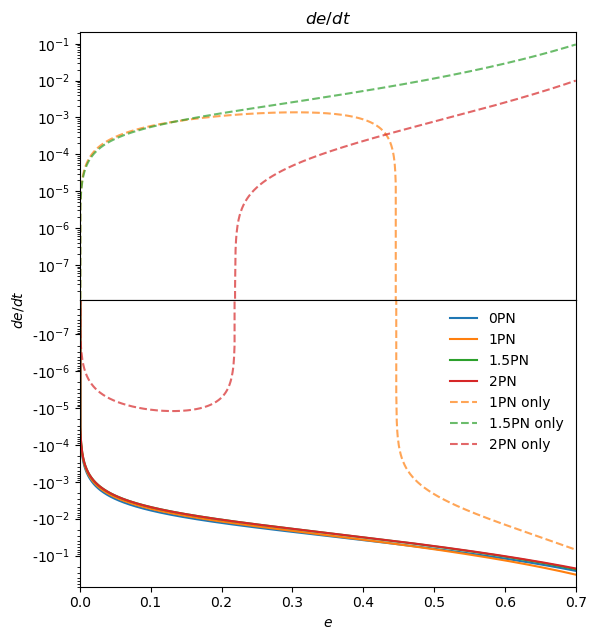

/tmp/ipykernel_1003259/1724834501.py:68: RuntimeWarning: invalid value encountered in divide
  evol_total_fracs = total/evol_totals[0]


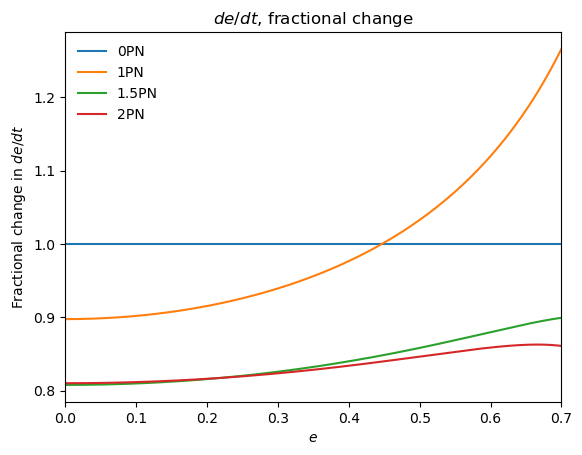

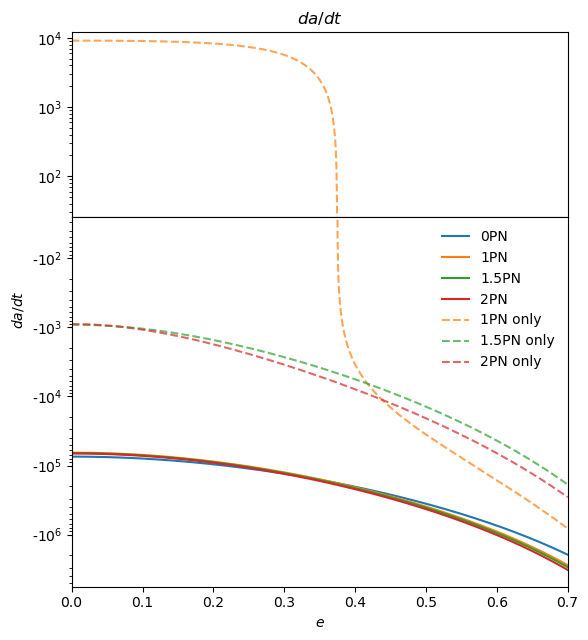

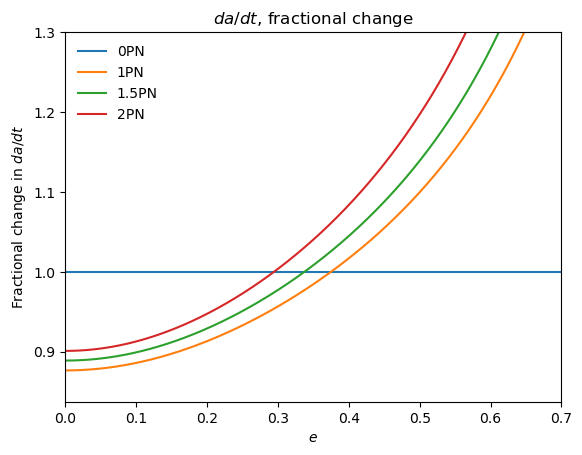

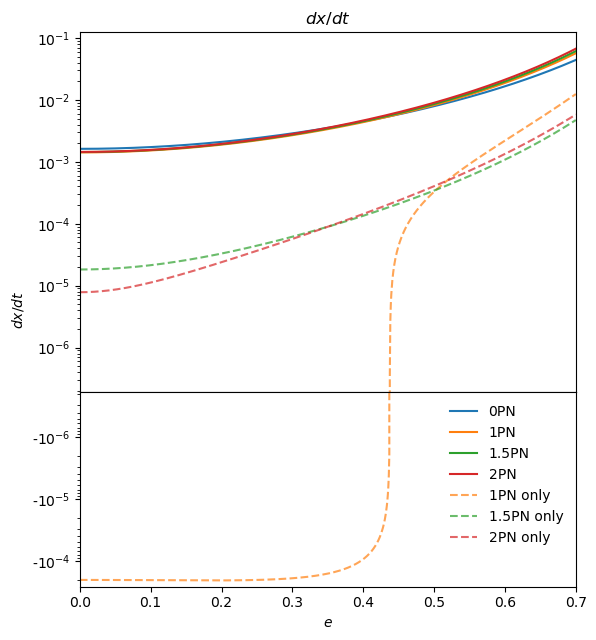

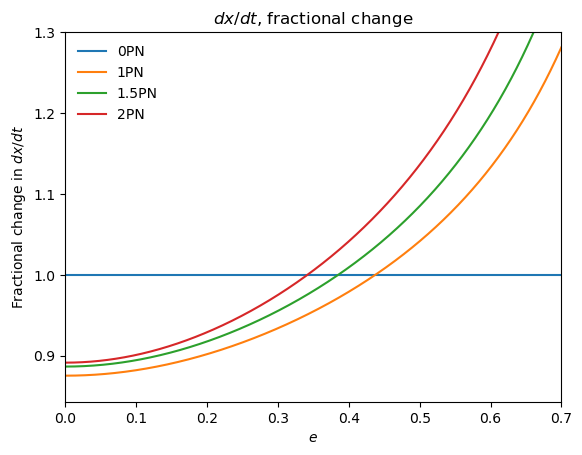

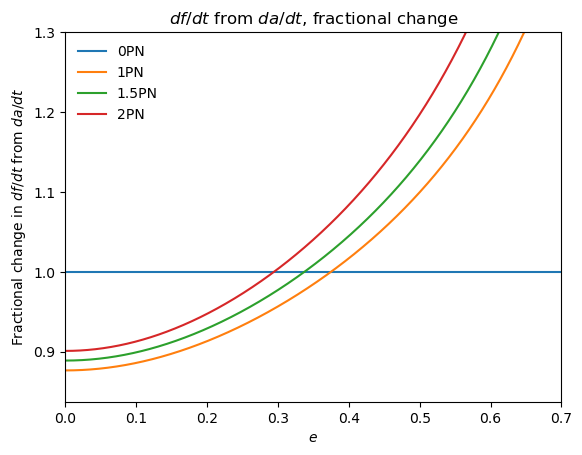

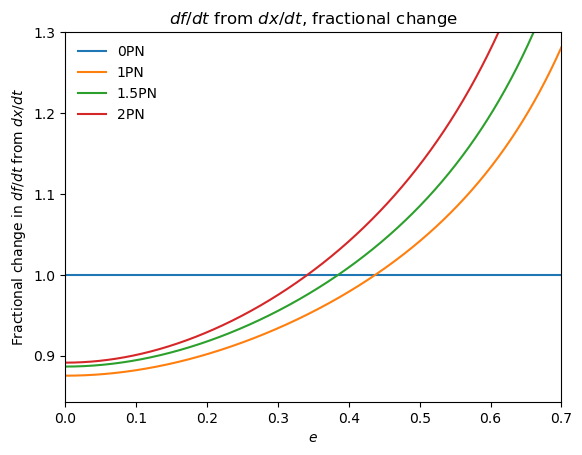

/tmp/ipykernel_1003259/2172605540.py:14: RuntimeWarning: invalid value encountered in divide
  result += 1*e/e


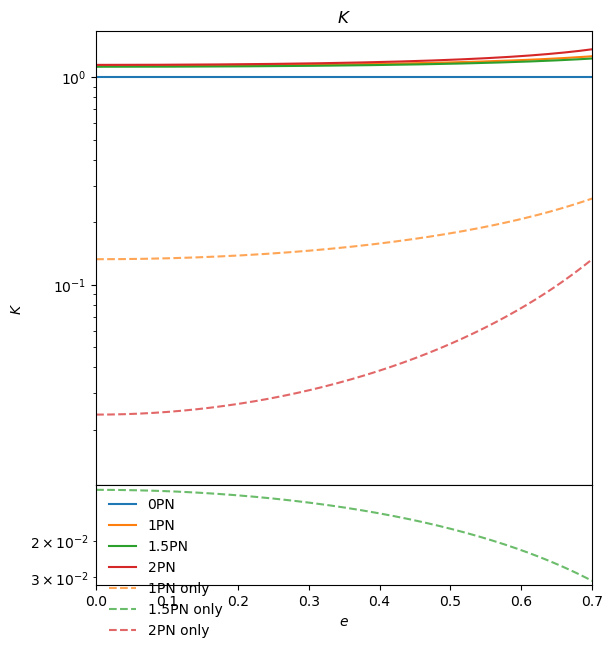

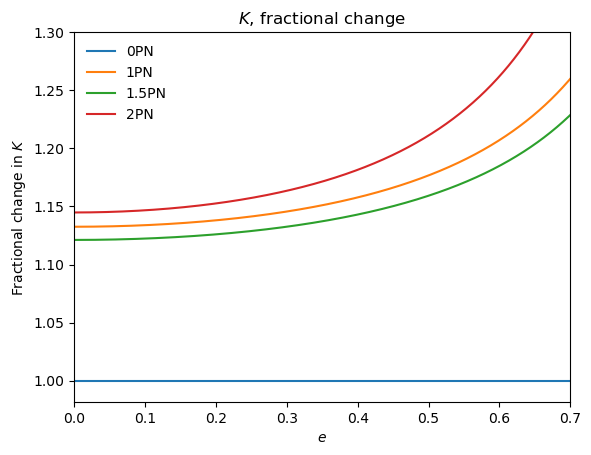

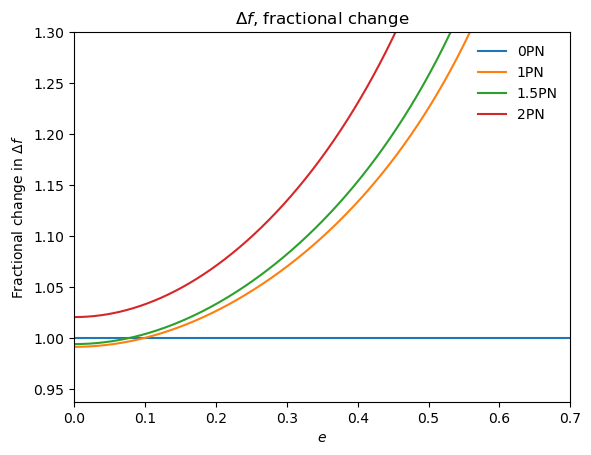

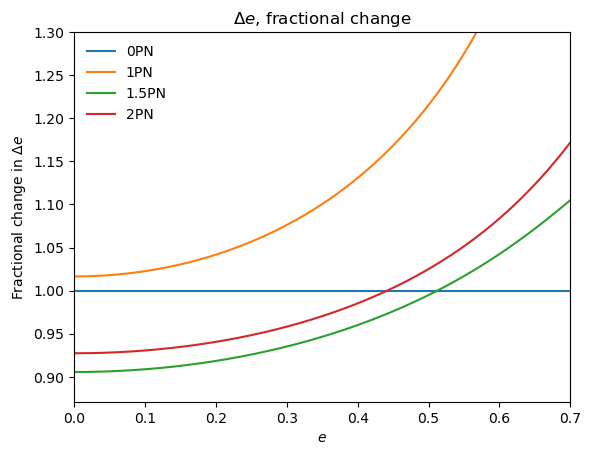

In [34]:
# Parameters
f = 10
M = 60
q = 2
chi1 = 0.5
chi2 = 0
pn = 2

# de_dt plots
plot_rel_strength(de_dt_evol, '$de/dt$', f, M, q, chi1, chi2, pn)

# da_dt plots
plot_rel_strength(da_dt_evol, '$da/dt$', f, M, q, chi1, chi2, pn)

#dx_dt plots
plot_rel_strength(dx_dt_evol, '$dx/dt$', f, M, q, chi1, chi2, pn)

#df_dt plots
plot_rel_strength(df_dt_from_da_dt, '$df/dt$ from $da/dt$', f, M, q, chi1, chi2, pn, plots=[1])
plot_rel_strength(df_dt_from_dx_dt, '$df/dt$ from $dx/dt$', f, M, q, chi1, chi2, pn, plots=[1])

# K plots
plot_rel_strength(K_from_xe, '$K$', f, M, q, chi1, chi2, pn)

# Delta f and Delta e equations
plot_rel_strength(shifted_f_pn, '$\Delta f$', f, M/aconst.M_sun.value, q, chi1, chi2, pn, plots=[1], delta_param='f')
plot_rel_strength(shifted_e_pn, '$\Delta e$', f, M/aconst.M_sun.value, q, chi1, chi2, pn, plots=[1], delta_param='e')

## Results

In [35]:
# Parameters
norm_f_low = 10
norm_e = 0.2
norm_M = 60
norm_q = 2
norm_chi1 = 0
norm_chi2 = 0

# High parameters
hi_e = 0.5
hi_q = 5
hi_chi1 = 0.5

### Non-extreme case

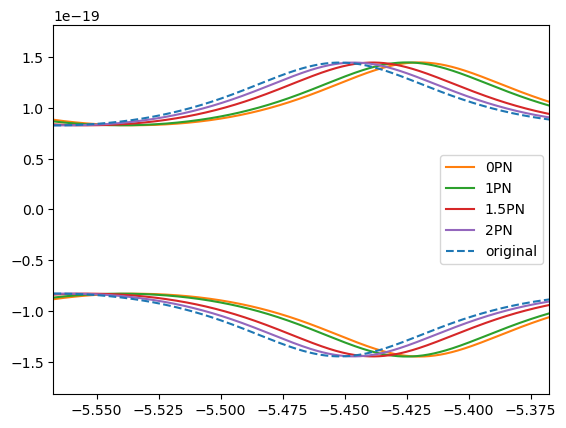

In [36]:
# Params
f_low, e, M, q, chi1, chi2 = norm_f_low, norm_e, norm_M, norm_q, norm_chi1, norm_chi2
pns = [0, 1, 1.5, 2]

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)
s_hs = []
for pn in pns:
    s_f = shifted_f_pn(f_low, e, M, q, chi1, chi2, pn=pn, niter=1)
    s_e = shifted_e_pn(f_low, e, M, q, chi1, chi2, pn=pn, niter=1)
    s_hs.append(gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2))

# Plot
for i in range(len(pns)):
    plt.plot(s_hs[i].sample_times, np.abs(s_hs[i]), c=f'C{i+1}', label=f'{pns[i]}PN')
    plt.plot(s_hs[i].sample_times, -np.abs(s_hs[i]), c=f'C{i+1}')
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', label='original')
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed')
plt.xlim(h.sample_times[0], h.sample_times[0]+0.2)
plt.ylim(-1.25*np.max(np.array(np.abs(h[:2048]))), 1.25*np.max(np.array(np.abs(h[:2048]))))
plt.legend()

### High eccentricity

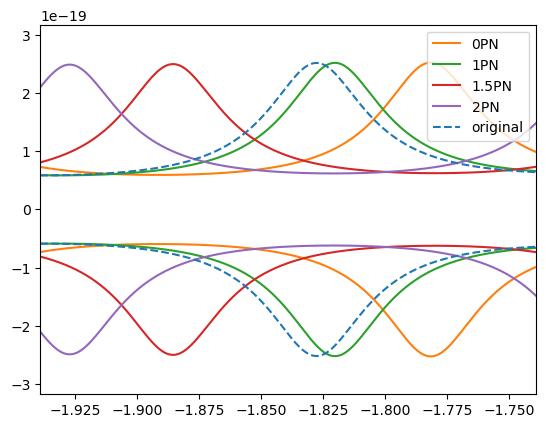

In [37]:
# Params
f_low, e, M, q, chi1, chi2 = norm_f_low, hi_e, norm_M, norm_q, norm_chi1, norm_chi2
pns = [0, 1, 1.5, 2]

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)
s_hs = []
for pn in pns:
    s_f = shifted_f_pn(f_low, e, M, q, chi1, chi2, pn=pn)
    s_e = shifted_e_pn(f_low, e, M, q, chi1, chi2, pn=pn)
    s_hs.append(gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2))

# Plot
for i in range(len(pns)):
    plt.plot(s_hs[i].sample_times, np.abs(s_hs[i]), c=f'C{i+1}', label=f'{pns[i]}PN')
    plt.plot(s_hs[i].sample_times, -np.abs(s_hs[i]), c=f'C{i+1}')
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', label='original')
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed')
plt.xlim(h.sample_times[0], h.sample_times[0]+0.2)
plt.ylim(-1.25*np.max(np.array(np.abs(h[:2048]))), 1.25*np.max(np.array(np.abs(h[:2048]))))
plt.legend()

### High mass ratio

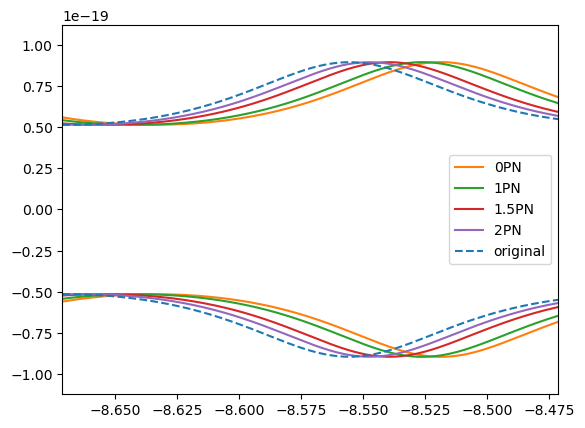

In [38]:
# Params
f_low, e, M, q, chi1, chi2 = norm_f_low, norm_e, norm_M, hi_q, norm_chi1, norm_chi2
pns = [0, 1, 1.5, 2]

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)
s_hs = []
for pn in pns:
    s_f = shifted_f_pn(f_low, e, M, q, chi1, chi2, pn=pn)
    s_e = shifted_e_pn(f_low, e, M, q, chi1, chi2, pn=pn)
    s_hs.append(gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2))

# Plot
for i in range(len(pns)):
    plt.plot(s_hs[i].sample_times, np.abs(s_hs[i]), c=f'C{i+1}', label=f'{pns[i]}PN')
    plt.plot(s_hs[i].sample_times, -np.abs(s_hs[i]), c=f'C{i+1}')
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', label='original')
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed')
plt.xlim(h.sample_times[0], h.sample_times[0]+0.2)
plt.ylim(-1.25*np.max(np.array(np.abs(h[:2048]))), 1.25*np.max(np.array(np.abs(h[:2048]))))
plt.legend()

### Aligned spin (+ve)

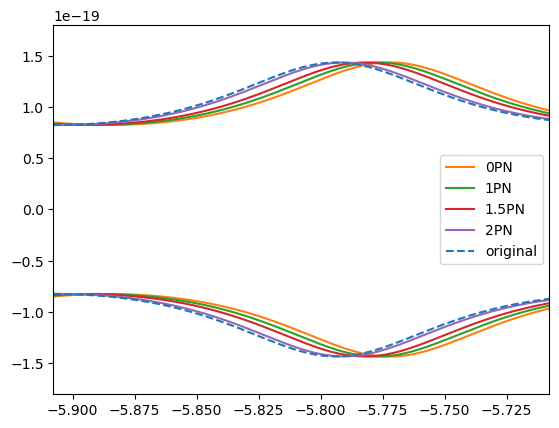

In [39]:
# Params
f_low, e, M, q, chi1, chi2 = norm_f_low, norm_e, norm_M, norm_q, hi_chi1, norm_chi2
pns = [0, 1, 1.5, 2]

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)
s_hs = []
for pn in pns:
    s_f = shifted_f_pn(f_low, e, M, q, chi1, chi2, pn=pn)
    s_e = shifted_e_pn(f_low, e, M, q, chi1, chi2, pn=pn)
    s_hs.append(gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2))

# Plot
for i in range(len(pns)):
    plt.plot(s_hs[i].sample_times, np.abs(s_hs[i]), c=f'C{i+1}', label=f'{pns[i]}PN')
    plt.plot(s_hs[i].sample_times, -np.abs(s_hs[i]), c=f'C{i+1}')
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', label='original')
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed')
plt.xlim(h.sample_times[0], h.sample_times[0]+0.2)
plt.ylim(-1.25*np.max(np.array(np.abs(h[:2048]))), 1.25*np.max(np.array(np.abs(h[:2048]))))
plt.legend()

### High eccentricity, high mass ratio, aligned spin (+ve)

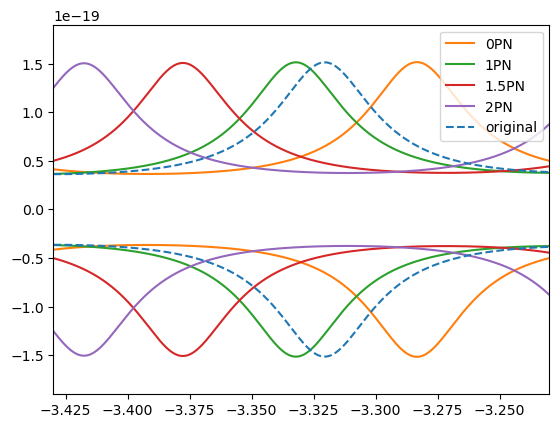

In [40]:
# Params
f_low, e, M, q, chi1, chi2 = norm_f_low, hi_e, norm_M, hi_q, hi_chi1, norm_chi2
pns = [0, 1, 1.5, 2]

# Waveform
h = gen_wf(f_low, e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2)
s_hs = []
for pn in pns:
    s_f = shifted_f_pn(f_low, e, M, q, chi1, chi2, pn=pn)
    s_e = shifted_e_pn(f_low, e, M, q, chi1, chi2, pn=pn)
    s_hs.append(gen_wf(s_f, s_e, M, q, 4096, 'TEOBResumS', chi1=chi1, chi2=chi2))

# Plot
for i in range(len(pns)):
    plt.plot(s_hs[i].sample_times, np.abs(s_hs[i]), c=f'C{i+1}', label=f'{pns[i]}PN')
    plt.plot(s_hs[i].sample_times, -np.abs(s_hs[i]), c=f'C{i+1}')
plt.plot(h.sample_times, np.abs(h), c='C0', ls='dashed', label='original')
plt.plot(h.sample_times, -np.abs(h), c='C0', ls='dashed')
plt.xlim(h.sample_times[0], h.sample_times[0]+0.2)
plt.ylim(-1.25*np.max(np.array(np.abs(h[:2048]))), 1.25*np.max(np.array(np.abs(h[:2048]))))
plt.legend()